# Проект "Телеком-1"

## Содержание (план проекта):

- **0.  Описание проекта**
- __Цель проекта
- __Описание услуг
- __Описание данных
- **1.  Знакомство с данными и их первичная предобработка**
- __Contract (датасет с информацией о договорах)
- __Personal (датасет с персональными данными клиентов)
- __Internet (датасет с информацией об интернет-услугах)
- __Phone (датасет с информацией об услугах телефонии)
- **2.  Анализ и подготовка данных**
- __Объединение данных в один датасет и финальная предобработка
- __Анализ распределения данных и корреляции численных признаков
- __Анализ баланса классов
- **3.  Моделирование**
- __Деление на выборки
- __Кодирование категориальных и масштабирование численных данных
- __Кросс-валидация с подбором гиперпараметров для модели LogisticRegression
- __Кросс-валидация с подбором гиперпараметров для модели RandomForestClassifier
- __Кросс-валидация с подбором гиперпараметров для модели CatBoostClassifier
- __Выбор лучшей модели
- **4.  Проверка лучшей модели на тестовых данных** 
- __Запуск лучшей модели на тестовых данных
- __Запуск baseline модели на тестовых данных
- __Анализ важности признаков модели
- __Матрица ошибок
- __Выводы
- **5.  Отчет о проделанной работе**

## Описание проекта

### Цель проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Целевой метрикой для заказчика является AUC-ROC с пороговым значением для подобранной модели не ниже 0.75.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

- BeginDate – дата начала пользования услугами;

- EndDate – дата окончания пользования услугами;

- Type – тип оплаты: ежемесячный, годовой и тд.;

- PaperlessBilling – безналичный расчет;

- PaymentMethod – способ оплаты;

- MonthlyCharges – ежемесячные траты на услуги;

- TotalCharges – всего потрачено денег на услуги;

- Dependents – наличие иждивенцев;

- Senior Citizen – наличие пенсионного статуса по возрасту;

- Partner – наличие супруга(и);

- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

## 1. Знакомство с данными и их первичная предобработка

In [101]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import phik
from phik.report import plot_correlation_matrix
from phik import report

from skimpy import clean_columns

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, \
roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

pd.options.mode.chained_assignment=None 

### Contract (датасет с информацией о договорах)

In [102]:
# читаем csv-файл с информацией о договоре и сохраняем в переменную contract
try:
    contract = pd.read_csv('/Users/sergeypervov/Downloads/contract_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv') 

contract.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2979,8996-ZROXE,2015-05-01,No,One year,Yes,Electronic check,53.50,3140.99
4505,6917-FIJHC,2014-02-01,2015-03-01,Two year,Yes,Mailed check,26.00,341.38
3642,2107-FBPTK,2017-08-01,No,Month-to-month,Yes,Electronic check,104.10,3123.0
4444,0137-UDEUO,2019-08-01,No,Month-to-month,No,Mailed check,19.85,119.1
1598,7552-KEYGT,2017-11-01,No,Two year,No,Bank transfer (automatic),19.55,527.85


In [103]:
contract.info() #  смотрим количество строк в датасете, наличие явных пропусков, наименования столбцов и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [104]:
contract.describe(include='all') # смотрим распределение данных в датасете на предмет явных аномалий и подсказок для более
                                 # подробного изучения

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


**Комментарий:** В датасете 7043 строки, в наименованиях столбцов использован CamelCase вместо snake_case, очевидных пропусков нет, однако в некоторых столбцах некорректный формат данных. Данные в столбце "TotalCharges" следует привести к типу "float64", как у ежемесячных расходов и 11 значений с пробелами уже обозначатся как пропуски, посмотрим дальше, что с ними делать. Ячейки с датами нужно привести к datetime, однако в столбце "EndDate" помимо дат присутствуют значения "No" - это означает, то контракт еще действует, то есть пользователь не отказался от услуг (таких значений 5942 из 7043). Для удобства работы с данными в столбцах, будет удобнее на основании данного столбца сформировать новый с целевым признаком churn (отток), где значение "1" будет присвоено клиентам, у которых обозначена конкретная дата окончания контракта, а "0" тем, у которых ее нет. После этого в столбце "EndDate" значения "No" можно будет заменить на текущую дату, чтобы вычислить длительность пользования услугами для клиентов (можно будет вместо 2 столбцов с датами оставить 1 фичу со сроком пользования услугами, что компактнее и проще интерпретировать), а так, как данные о договорах актуальны на 1 февраля 2020, то эту дату можно использовать в качестве текущей. Уже из описания данных видно, что все клиентские номера уникальны, так что можно не проверять таблицу на дубликаты. Категориальные признаки "Type", "PaperlessBilling" и "PaymentMethod" имеют 3, 2 и 4 уникальных значений, посмотрим на них поподробнее на предмет неявных дубликатов или аномалий. 

In [105]:
# смотрим уникальные значения в категориальных данных на предмет неявных дубликатов или аномалий
contract_cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod']
for col in contract_cat_cols:
    print('**********')
    print(f'Распределение значений в столбце {col}')
    print(contract[col].value_counts())

**********
Распределение значений в столбце Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
**********
Распределение значений в столбце PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
**********
Распределение значений в столбце PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


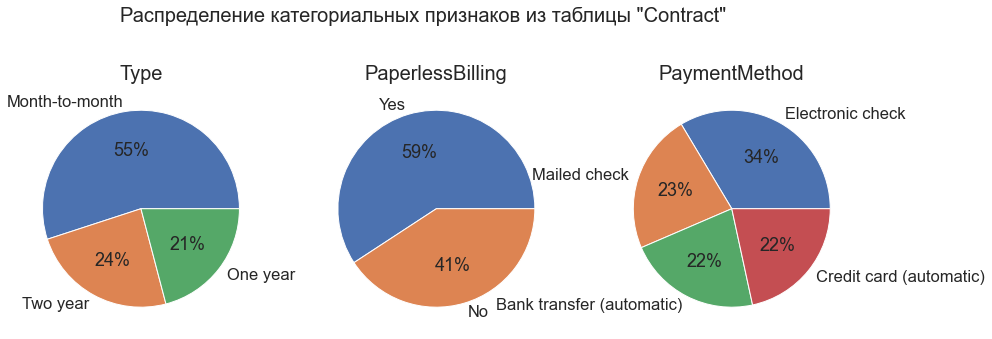

In [106]:
# для наглядности визуализируем распределения
plt.figure(figsize=[15, 6])
plt.suptitle('Распределение категориальных признаков из таблицы "Contract"', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.2)

i = 0
for col in contract_cat_cols:
    i += 1
    plt.subplot(1, 3, i)
    plt.title(f'{col}', fontsize=20)
    contract[col].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%")
    #plt.pie(contract[col].value_counts(), labels=contract[col].unique(), autopct="%1.0f%%");

**Комментарий:** Неявных дубликатов не обнаружено. 

Ознакомились с распределением категориальных данных, а именно type (тип контракта): Month-to-month (ежемесячный тариф самый популярный - 55% клиентов), Two year (2-годичный договор - 24% клиентов) и One year (годичный договор - 21% клиентов); paperless_billing (безналичный расчет) почти у 60%: Yes (да - 59% клиентов) и No (нет - 41%); payment_method (способ оплаты): Electronic check - самый популярный (электронный чек - 34%), Mailed check (чек почтовым отправлением - 23%), Bank transfer (automatic)  (банковский перевод (автоматический) - 22%) и Credit card (automatic) (кредитная карта (автоматический) - 22%).

Вносим описанные выше корректировки и проверяем результат.

In [107]:
contract = clean_columns(contract)
list(contract.columns)

8 column names have been cleaned

['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges']

In [110]:
# пишем функцию для категоризации оттока с подстраховкой на случай каких-то еще значений в столбце
def categorize_churn(end_date):
    try:
        if end_date == 'No':
            return 0
        else:
            return 1
    except:
        pass

In [111]:
# добавляем столбец с бинарными данными по фактам оттока клиентов, это и будет наш целевой признак

contract['churn'] = contract['end_date'].apply(categorize_churn)

contract.sample(5) 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
1841,8958-JPTRR,2015-06-01,No,One year,No,Electronic check,24.30,1388.02,0
4479,5075-JSDKI,2015-03-01,No,Two year,No,Electronic check,24.45,1557.95,0
6709,7103-IPXPJ,2015-12-01,No,One year,No,Electronic check,99.40,4970.0,0
1825,5423-BHIXO,2017-06-01,No,Month-to-month,Yes,Electronic check,54.20,1890.5,0
4332,4194-FJARJ,2015-08-01,2017-09-01,Two year,No,Bank transfer (automatic),60.00,1605.0,1


In [112]:
contract['churn'].value_counts() #  проверяем соответствие по кол-ву "0", соответствующему "No", а заодно на наличие аномалий

0    5942
1    1101
Name: churn, dtype: int64

In [113]:
# теперь можно поменять заменить значения "No" на выбранную ранее дату 1 февраля 2020, чтобы привести столбец к нужному формату

contract['end_date'] = contract['end_date'].replace(['No'], ['2020-02-01'])
len(contract[contract['end_date'] == 'No'])

0

In [114]:
# переведем данные в столбцах с датами в соответствующий формат

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   churn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


In [115]:
# добавим столбец с длительностью контракта в днях по состоянию на 01 февраля 2020 (разность между открытием и закрытием)
contract['loyalty_period'] = (contract['end_date'] - contract['begin_date']).dt.days
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


In [116]:
# изменим тип данных в столбце "total_charges" на числовой, а так как там есть пробелы, указываем метод обработки ошибок, 
# при котором они будут обозначаться как "NaN"
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors ='coerce') 
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int64         
 9   loyalty_period     7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


**Комментарий:** Теперь все данные в столбцах корректно отформатированы, однако у нас ожидаемо возникли пропуски в столбце "total_charges" - разберемся с ними. Для этого посмотрим на эти 11 строк подробнее.

In [117]:
contract[contract['total_charges'].isna()] # смотрим все строки с пропусками в итоговых затратах клиентов

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


In [118]:
contract[contract['loyalty_period'] == 0] # на всякий слуай перепроверим все строки, где контракт действовал 0 дней на 1.02

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


**Комментарий:** Видим, что пропуски соответствуют клиентам, у которых срок действия контракта 0 дней, так как дата его оформления 01 февраля 2020. Это просто новые пользователи, которые еще не успели ничего заплатить, поэтому пропуски можно заполнить нулями.

In [119]:
contract['total_charges'] = contract['total_charges'].fillna(0) # заполняем пропуски и перепроверяем
contract['total_charges'].isna().sum()

0

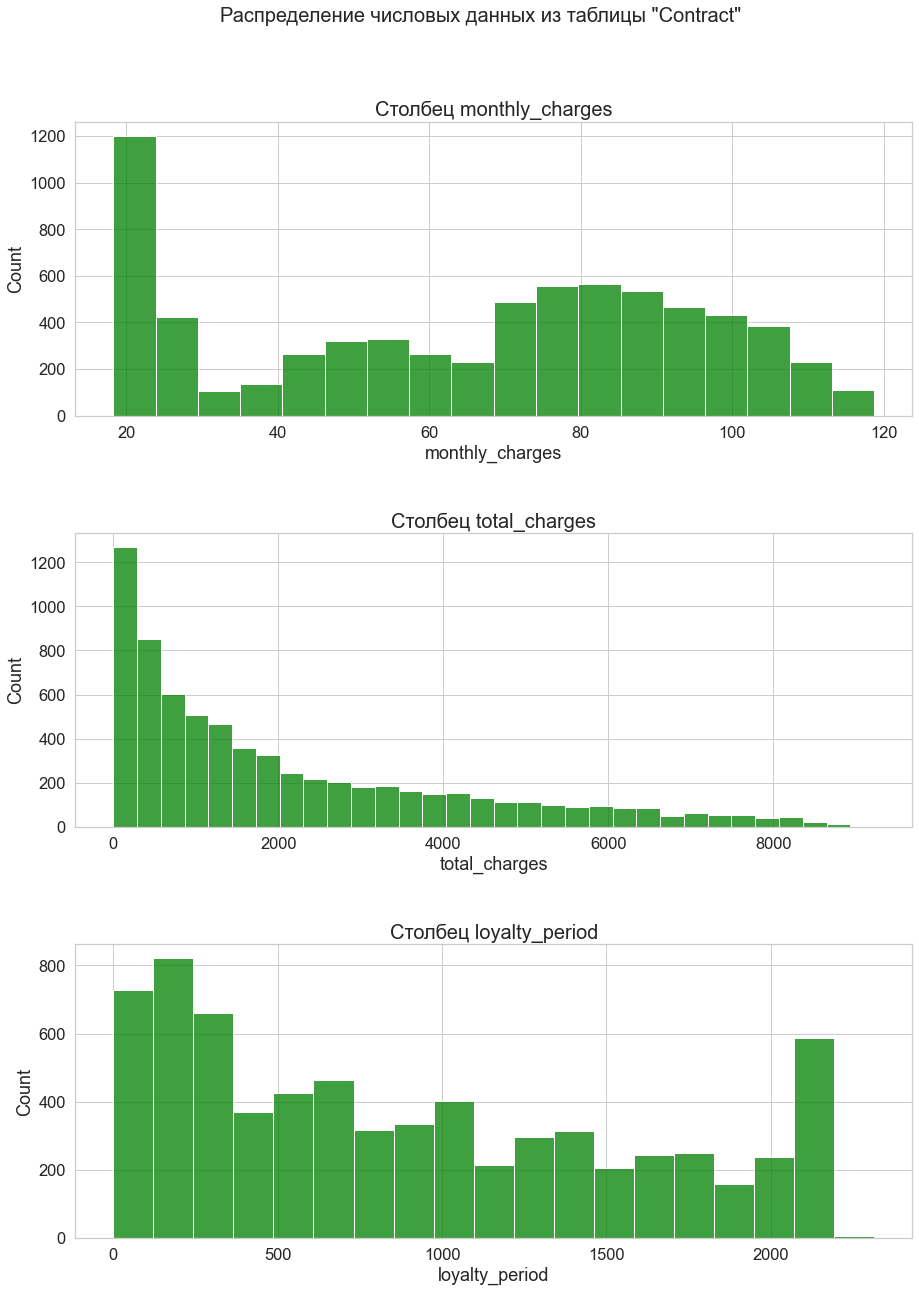

In [120]:
# ознакомимся с распределением числовых данных
contract_num_cols = ['monthly_charges', 'total_charges', 'loyalty_period']

plt.figure(figsize=[15, 20])
plt.suptitle('Распределение числовых данных из таблицы "Contract"', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.4)

i = 0
for col in contract_num_cols:
    i += 1
    plt.subplot(3, 1, i)
    plt.title(f'Столбец {col}', fontsize=20)
    sns.histplot(data=contract, x=col, color='green', edgecolor='white');

**Комментарий:** В распределении ежемесячных платежей (monthly_charges) есть несколько пиков: самый выраженный в районе +/- 20 единиц (объемом около 1200 клиентов), еще небольшое плато в районе +/- 50 единиц (объемом в 300-600 клиентов) и плато побольше в районе +/- 80 единиц (объемом в 500-1000 клиентов). Возможно, это разные ценовые группы клиентов, в подробном анализе нужно будет посмотреть, как отток распределяется относительно этих пиков. Итоговые платежи (total_charges) начинают с пика в районе нуля (скорее всего, это недавние клиенты) и по мере увеличения суммы частота идет на спад. Все-таки, с точки зрения дифференциации клиентов удобнее смотреть на ежемесячные платежи. Что касается сгенерированной нами фичи - клиентского стажа (loyalty_period), то его частота тоже постепенно снижается от максимальных объемов, приходящихся на диапазон от 0 до примерно года равномерно, но с локальными пиками (попробуем в анализе как-то покрутить эти данные, может в сравнении с датой начала контракта получится найти какие-то инсайты), также интересен пик в районе стажа 6 лет (также покрутим при исследовательском анализе). 

In [121]:
# когда все данные приведены в порядок можно еще раз глянуть на их распределения в поисках возможных инсайтов
contract.describe(include='all')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
unique,7043,77,67,3,2,4,NaN,NaN,NaN,NaN
top,7590-VHVEG,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN
freq,1,366,5942,3875,4171,2365,NaN,NaN,NaN,NaN
first,NaN,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885,0.156325,898.555729
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814,0.363189,683.130510
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,0.000000,276.000000


In [122]:
# посмотрим, сколько клиентов идут рука об руку с компанией с первого дня и все еще лояльны
contract[contract['loyalty_period'] >= 2300]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
3439,0917-EZOLA,2013-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),104.15,7915.40,0,2314
4513,8580-QVLOC,2013-10-01,2020-02-01,Two year,No,Credit card (automatic),92.45,7026.20,0,2314
4610,2889-FPWRM,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),117.80,9221.38,0,2314


In [123]:
# заодно глянем, сколько всего их было изначально
contract[contract['begin_date'] == '2013-10-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period
3439,0917-EZOLA,2013-10-01,2020-02-01,Two year,Yes,Bank transfer (automatic),104.15,7915.40,0,2314
4513,8580-QVLOC,2013-10-01,2020-02-01,Two year,No,Credit card (automatic),92.45,7026.20,0,2314
4610,2889-FPWRM,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),117.80,9221.38,0,2314


**Вывод:** Перед нами данные по контрактам с 1 октября 2013 по 01 февраля 2020 строки, то есть за 6 лет и 4 месяца. При этом максимальное значение среди клиентских стажей в днях соответствует этому сроку, то есть есть, как минимум один действующий клиент, который был с оператором с самого начала. Точнее таких клиентов 3, их номера id: "0917-EZOLA", "8580-QVLOC" и "2889-FPWR". Возможно, отделу маркетинга или клиентскому отделу также захочется как-то отработать и такую лояльность.

Наименования столбцов исправлены, пропусков нет, форматы данных корректные, таргет извлечен, сгенерирована новая фича в виде стажа клиента в днях, благодаря чему столбцы с датами начала и конца договора можно удалить. Таким образом, получатся 3 численные фичи: loyalty_period (стаж клинента в днях), monthly_charges (ежемесячные платежи), total_charges (суммарныке платежи) и 3 категориальные + целевая переменная. 

Поподробнее о численных данных. В распределении ежемесячных платежей (monthly_charges) есть несколько пиков: самый выраженный в районе +/- 20 единиц (объемом около 1200 клиентов), еще небольшое плато в районе +/- 50 единиц (объемом в 300-600 клиентов) и плато побольше в районе +/- 80 единиц (объемом в 500-1000 клиентов). Возможно, это разные ценовые группы клиентов, в подробном анализе нужно будет посмотреть, как отток распределяется относительно этих пиков. Итоговые платежи (total_charges) начинают с пика в районе нуля (скорее всего, это недавние клиенты) и по мере увеличения суммы частота идет на спад. Все-таки, с точки зрения дифференциации клиентов удобнее смотреть на ежемесячные платежи. Что касается сгенерированной нами фичи - клиентского стажа (loyalty_period), то его частота тоже постепенно снижается от максимальных объемов, приходящихся на диапазон от 0 до примерно года равномерно, но с локальными пиками (попробуем в анализе как-то покрутить эти данные, может в сравнении с датой начала контракта получится найти какие-то инсайты), также интересен пик в районе стажа 6 лет (также покрутим при исследовательском анализе). 

Категориальные - это type (тип контракта): Month-to-month (ежемесячный тариф самый популярный - 55% клиентов), Two year (2-годичный договор - 24% клиентов) и One year (годичный договор - 21% клиентов); paperless_billing (безналичный расчет) почти у 60%: Yes (да - 59% клиентов) и No (нет - 41%); payment_method (способ оплаты): Electronic check - самый популярный (электронный чек - 34%), Mailed check (чек почтовым отправлением - 23%), Bank transfer (automatic)  (банковский перевод (автоматический) - 22%) и Credit card (automatic) (кредитная карта (автоматический) - 22%). 

### Personal (датасет с персональными данными клиентов)

In [124]:
# читаем csv-файл с персональными данными клиента и сохраняем в переменную personal
try:
    personal = pd.read_csv('/Users/sergeypervov/Downloads/personal_new.csv')
except:
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv') 

personal.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,customerID,gender,SeniorCitizen,Partner,Dependents
2841,9743-DQKQW,Male,0,No,No
2555,1849-RJYIG,Female,0,No,No
3480,6060-QBMGV,Male,0,Yes,No
6465,8164-OCKUJ,Female,0,Yes,Yes
7002,9586-JGQKH,Female,0,Yes,No


In [125]:
personal.info() #  смотрим количество строк в датасете, наличие явных пропусков, наименования столбцов и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [126]:
personal.describe(include='all') # смотрим распределение данных в датасете на предмет явных аномалий и подсказок для более
                                 # подробного изучения

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


**Комментарий:** Аналогично таблице с информацией по контрактам здесь 7043 строки (ниже проверим, соответствуют ли все ID клиентов в этих датасетах), присутствуют аналогичные недочеты в наименованиях столбцов, пропусков нет, формат данных в столбцах адекватный. Категориальные признаки "gender", "Partner" и "Dependents" принимают по 2 уникальных значения: "Male" (3555 из 7043 клиентов) / "Female" и "Yes"/"No" (3641 и 4933 из 7043 клиентов соответственно). Посмотрим на распределения в более наглядном виде.

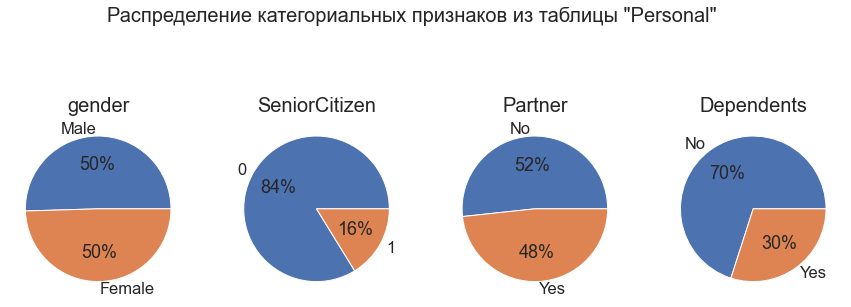

In [127]:
# для наглядности визуализируем распределения категориальных величин
personal_cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

plt.figure(figsize=[15, 6])
plt.suptitle('Распределение категориальных признаков из таблицы "Personal"', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.2)

i = 0
for col in personal_cat_cols:
    i += 1
    plt.subplot(1, 4, i)
    plt.title(f'{col}', fontsize=20)
    personal[col].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%")
    #plt.pie(personal[col].value_counts(), labels=personal[col].unique(), autopct="%1.0f%%");

In [128]:
personal['customerID'].isin(contract['customer_id']).unique() # проверим соответствие ID клиентов в первых 2х датасетах

array([ True])

In [129]:
personal['customerID'].is_unique # также проверим, нет ли дубликатов в номерах клиентов внутри таблицы

True

In [130]:
personal = clean_columns(personal)
list(personal.columns)

4 column names have been cleaned

['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

**Вывод:** В таблице 7043 строки, дубликатов нет, пропусков нет, формат данных адекватный, наименования столбцов приведены в норму.

Категориальные признаки "gender", "Partner" и "Dependents" принимают по 2 уникальных значения: мужчин и женщин примерно поровну, 84% клиентов не являются пожилыми/пенсионерами (значение параметра уточняется), чуть больше половины клиентов (52%) не имеют партнера (значение параметра уточняется) и 70% клиентов не имеют иждивенцев.

Номера клиентов аналогичны датасету с данными о договорах, так что таблицы можно будет соединить по customer_id.

### Internet (датасет с информацией об интернет-услугах)

In [133]:
# читаем csv-файл с информацией об интернет-услугах и сохраняем в переменную internet
try:
    internet = pd.read_csv('/Users/sergeypervov/Downloads/internet_new.csv')
except:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv') 

internet.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3744,3717-LNXKW,Fiber optic,Yes,No,No,No,Yes,No
2144,1110-KYLGQ,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
3093,4505-EXZHB,Fiber optic,No,No,Yes,No,No,No
4629,6496-SLWHQ,Fiber optic,No,Yes,Yes,No,Yes,Yes
1730,5931-FLJJF,Fiber optic,No,No,No,No,No,No


In [134]:
internet.info() #  смотрим количество строк в датасете, наличие явных пропусков, наименования столбцов и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [135]:
internet.describe(include='all') # смотрим распределение данных в датасете на предмет явных аномалий и подсказок для более
                                 # подробного изучения

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


**Комментарий:** В данной таблице уже 5517 строк, что нормально, так как не у всех клиентов в базе может быть подключен интернет. Аналогичные предыдущим таблицам отклонения в наименованиях столбцов (исправим это). Пропусков нет, формат данных адекватный, все данные категориальные по 2 варианта: DSL или Fiber optic для типа подключения (второй имеет 3096 клиентов из 5517) и Yes или No для доп. сервисов (интернет безопасность не подключают 3498 клиентов, облачный бэкап - 3088, защиту устройства - 3095, тех поддержку - 3473, стриминговое ТВ - 2810 и стриминг фильмов - 2785 из 5517). Нагляднее посмотрим на диаграммах. А далее проверим, все ли номера клиентов взяты из предыдущих 2 таблиц.

In [136]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

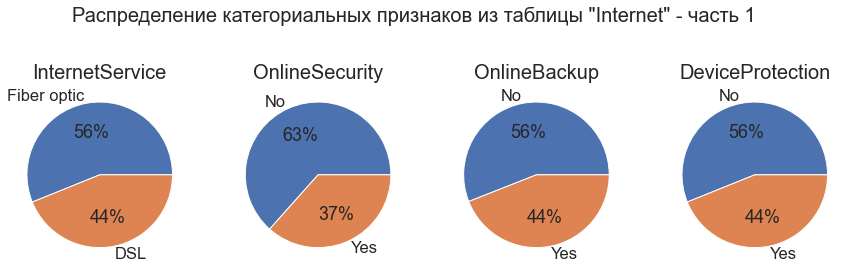

In [137]:
# для наглядности визуализируем распределения категориальных величин
internet_cat_cols_one = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'] 

plt.figure(figsize=[15, 5])
plt.suptitle('Распределение категориальных признаков из таблицы "Internet" - часть 1', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.2)

i = 0
for col in internet_cat_cols_one:
    i += 1
    plt.subplot(1, 4, i)
    plt.title(f'{col}', fontsize=20)
    internet[col].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%")
    #plt.pie(internet[col].value_counts(), labels=internet[col].unique(), autopct="%1.0f%%");

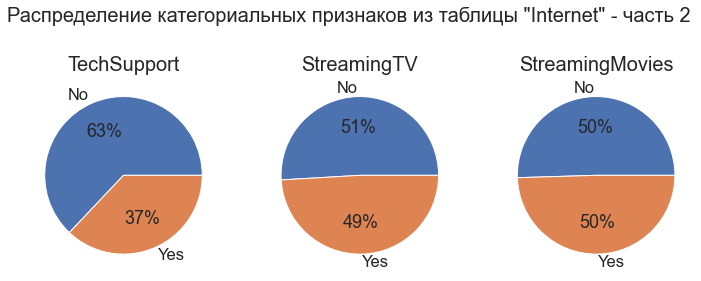

In [138]:
internet_cat_cols_two = ['TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=[12, 5])
plt.suptitle('Распределение категориальных признаков из таблицы "Internet" - часть 2', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.2)

i = 0
for col in internet_cat_cols_two:
    i += 1
    plt.subplot(1, 3, i)
    plt.title(f'{col}', fontsize=20)
    internet[col].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%")
    #plt.pie(internet[col].value_counts(), labels=internet[col].unique(), autopct="%1.0f%%")

In [139]:
internet['customerID'].isin(contract['customer_id']).unique() #проверим,что ID клиентов только из списков в первых таблицах

array([ True])

In [140]:
internet['customerID'].is_unique # также проверим, нет ли дубликатов в номерах клиентов внутри таблицы

True

In [141]:
internet = clean_columns(internet)
list(internet.columns)

8 column names have been cleaned

['customer_id',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

**Вывод:** В таблице 5517 строк, дубликатов нет, пропусков нет, формат данных адекватный, наименования столбцов приведены в норму.

Все данные категориальные по 2 варианта: тип подключения Fiber optic (56%) более популярен, чем DSL, остальные - это доп. сервисы (интернет безопасность не подключают 63% абонентов интернет услуг, облачный бэкап - 56%, защиту устройства - 56%, тех поддержку - 63%, стриминговое ТВ - 51% и стриминг фильмов - 50%).

Номера клиентов аналогичны датасету с данными о договорах, так что таблицу можно присоединить к предыдущим 2м по customer_id.

### Phone (датасет с информацией об услугах телефонии)

In [144]:
# читаем csv-файл с информацией об услугах телефонии и сохраняем в переменную phone
try:
    phone = pd.read_csv('/Users/sergeypervov/Downloads/phone_new.csv')
except:
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv') 

phone.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,customerID,MultipleLines
4435,7869-ZYDST,Yes
261,8203-XJZRC,No
3287,0491-KAPQG,Yes
4114,0423-UDIJQ,No
3383,1097-FSPVW,No


In [145]:
phone.info() #  смотрим количество строк в датасете, наличие явных пропусков, наименования столбцов и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [146]:
phone.describe(include='all') # смотрим распределение данных в датасете на предмет явных аномалий и подсказок для более
                                 # подробного изучения

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**Комментарий:** В данной таблице уже 6361 строка, что нормально, так как не у всех клиентов в базе может быть подключена телефония. Аналогичные предыдущим таблицам отклонения в наименованиях столбцов (исправим это). Пропусков нет, формат данных адекватный, данные помимо ID категориальные с 2 вариантами: Yes или No (3390 из 6361 клиентов) для возможности ведения параллельных линий. Посмотрим распределение категориальных величин на графике, а затем проверим, все ли номера клиентов взяты из предыдущих 2 таблиц.

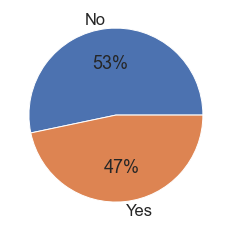

In [147]:
phone['MultipleLines'].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%");

In [148]:
phone['customerID'].isin(contract['customer_id']).unique() #проверим,что ID клиентов только из списков в первых таблицах

array([ True])

In [149]:
phone['customerID'].is_unique # также проверим, нет ли дубликатов в номерах клиентов внутри таблицы

True

In [150]:
phone = clean_columns(phone)
list(phone.columns)

2 column names have been cleaned

['customer_id', 'multiple_lines']

**Вывод:** В таблице 6361 строка, дубликатов нет, пропусков нет, формат данных адекватный, наименования столбцов приведены в норму.

1 категориальный столбец с данными о возможности ведения параллельных линий - 53% из абонентов телефонной связи не подключают эту услугу.

Номера клиентов аналогичны датасету с данными о договорах, так что таблицу можно присоединить к первым 2м по customer_id.

## 2. Анализ и подготовка данных

### Объединение данных в один датасет и финальная предобработка

In [153]:
#объединяем таблицы в один датасет
df = contract.merge(personal, how='left', on='customer_id').merge(internet, how='left', on='customer_id') \
    .merge(phone, how='left', on='customer_id')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [154]:
#перепроверяем, все ли id уникальны
df['customer_id'].is_unique

True

In [155]:
#смотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   loyalty_period     7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

**Комментарий:** Ожидаемо, при соединении таблиц возникли пропуски там, где у клиента не подключены какие-то из сервисов, соответственно, данные пропуски можно заполнить значениями "No". 

#В случае с типом интернет подключения по признаку "No" мы узнаем пользователей, не использующих интернет вообше, но не будет способа отличить пользователей, не использующих мобильную связь. Для этого заменим пропуски в столбце multiple_lines на значение "no_phone". 

In [156]:
service_columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', \
                  'streaming_tv', 'streaming_movies']

In [157]:
#заполняем пропуски
for column in service_columns:
    df[column] = df[column].fillna('No')

In [158]:
#заполняем пропуски
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

In [159]:
#смотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   loyalty_period     7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

In [160]:
#смотрим, что получилось
df['multiple_lines'].value_counts()

No          3390
Yes         2971
no_phone     682
Name: multiple_lines, dtype: int64

In [161]:
#смотрим, что получилось
df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: internet_service, dtype: int64

### Анализ распределения данных и корреляции численных признаков

**Работа с датами:** Мы не будем использовать даты при обучении, однако это не повод попробовать поискать в них какие-то инсайты для компании, пока они еще не удалены из датасета. Рассмотрим поподробнее распределения дат открытия и закрытия договоров.

In [162]:
df_dates = df.copy()

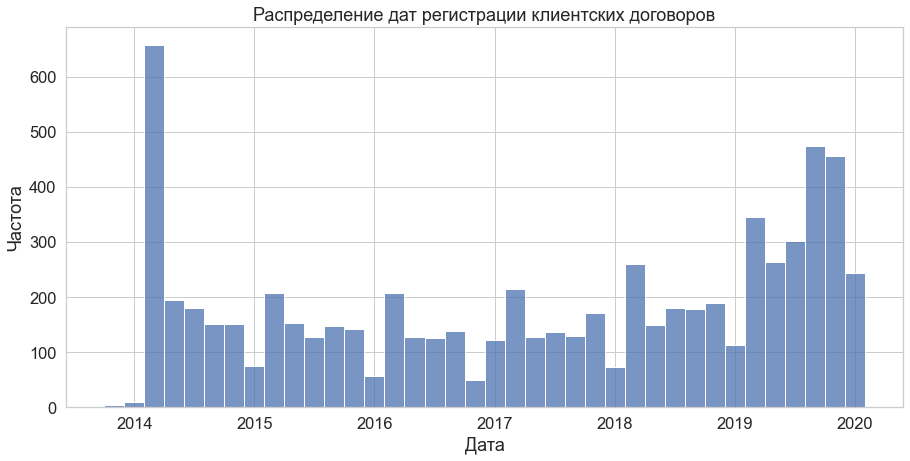

In [163]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates['begin_date'], bins=38)
plt.title('Распределение дат регистрации клиентских договоров')
plt.xlabel('Дата')
plt.ylabel('Частота');

In [164]:
df_dates['begin_date_month'] = df_dates['begin_date'].dt.month
df_dates['begin_date_year'] = df_dates['begin_date'].dt.year

In [165]:
#посмотрим приток клиентов по годам (отсортируем по убыванию притока)
annual_clients = df_dates.groupby(['begin_date_year'])['begin_date'].agg('count').reset_index() 
annual_clients.sort_values(by='begin_date', ascending=False)

,begin_date_year,begin_date
6,2019,1957
1,2014,1344
5,2018,1030
2,2015,852
4,2017,845
3,2016,763
7,2020,244
0,2013,8


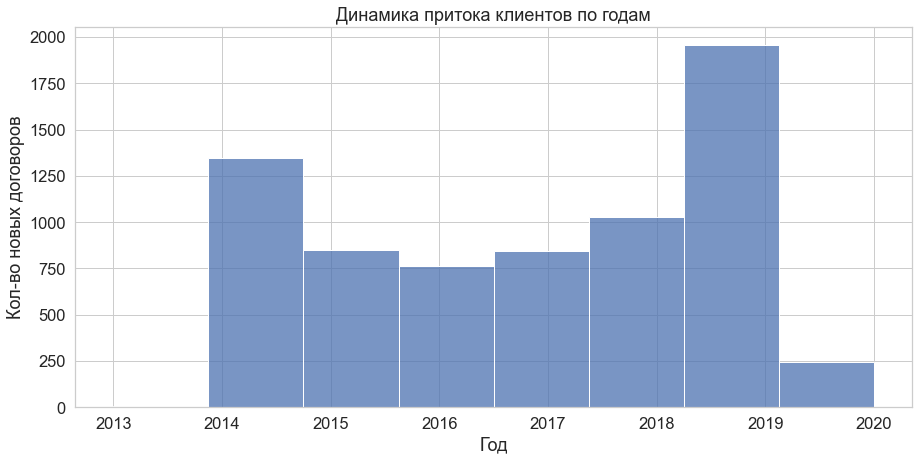

In [166]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates['begin_date_year'], bins=8)
plt.title('Динамика притока клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Кол-во новых договоров');

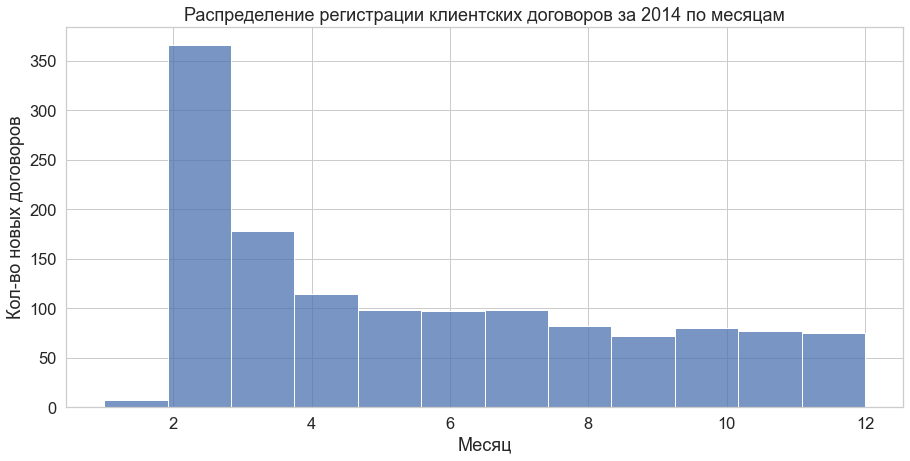

In [167]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates[df_dates['begin_date_year'] == 2014]['begin_date_month'], bins=12)
plt.title('Распределение регистрации клиентских договоров за 2014 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во новых договоров');

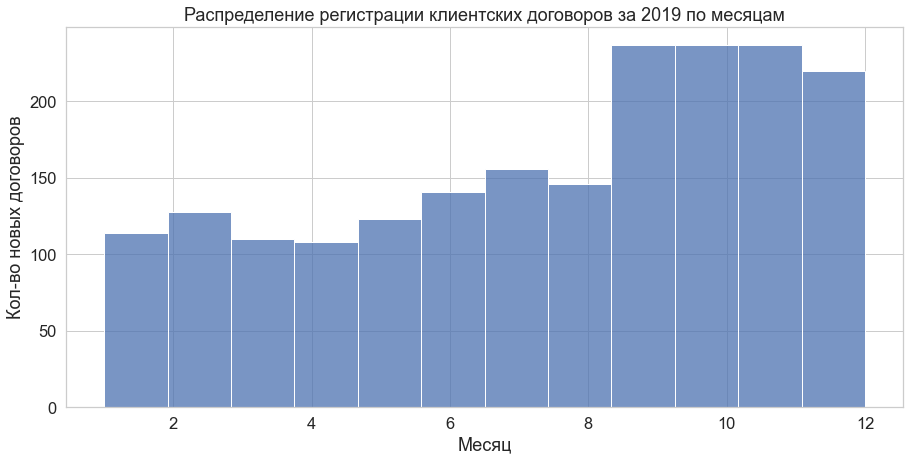

In [168]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates[df_dates['begin_date_year'] == 2019]['begin_date_month'], bins=12)
plt.title('Распределение регистрации клиентских договоров за 2019 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во новых договоров');

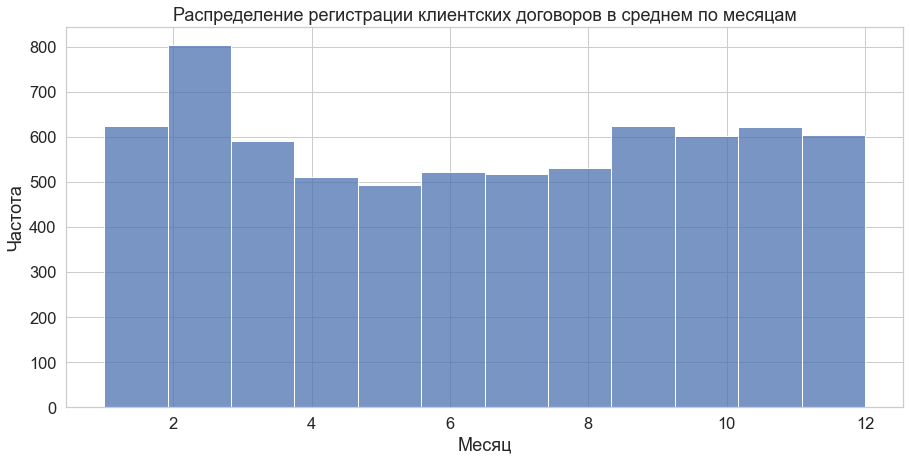

In [169]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates['begin_date_month'], bins=12)
plt.title('Распределение регистрации клиентских договоров в среднем по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Частота');

**Комментарий:** Большой приток новых пользователей был в начале 2014 года, видимо когда о новом операторе узнало достаточное кол-во людей и скорее всего были какие-то заманчивые предложения, чтобы перебить конкурентов и взять долю рынка, потом с 2014 по 2016 шел спад с похожей динамикой в течение года, а с 2017 пошел рост притока, пик которого пришелся на 2019 год. Пики в 2014 и максимальным в 2019 скорее всего объясняют пики в кол-вах клиентов со стажем в районе 6 лет и максимальным в районе минимального стажа. Что касается распределения в рамках года, то не будем детально разбирать динамику в каждом году, посмотрим только 2 самых успешных и в среднем за весь период. В 2014 ярко выраженный пик пришелся на февраль, после шел постепенный спад, в 2019 же самыми успешными выдались последние 4 месяца года. Это скорее на заметку отделу маркетинга для лучшего понимания притока клиентов (только они смогут сопоставить эти показатели с датами рекламных компаний, акций и т.п.). Посмотрим, что нам смогут рассказать даты окончания договоров.

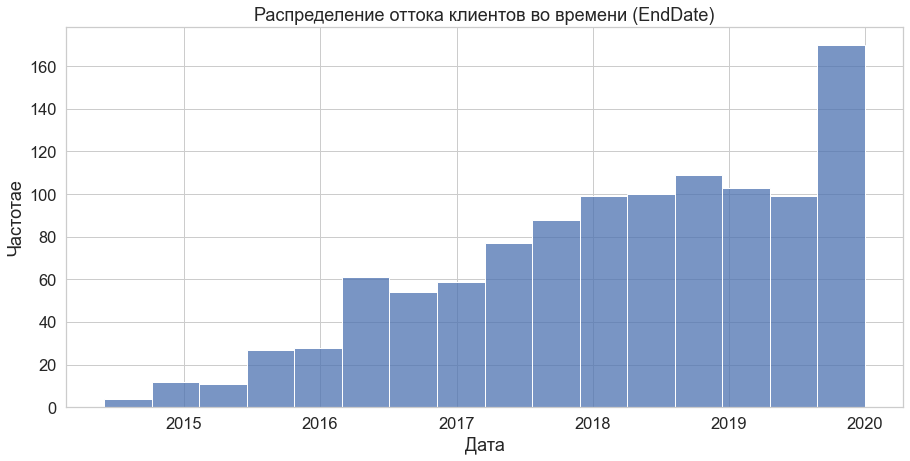

In [170]:
plt.figure(figsize=[15, 7])
sns.histplot(df_dates[df_dates['churn'] == 1]['end_date'])
plt.title('Распределение оттока клиентов во времени (EndDate)')
plt.xlabel('Дата')
plt.ylabel('Частотае');

In [171]:
#топ 10 дат по оттоку для отделов маркетинга и работы с клиентами
df_dates[df_dates['churn'] == 1]['end_date'].value_counts().head(10)

2020-01-01    39
2019-12-01    38
2018-11-01    35
2019-09-01    32
2019-10-01    31
2019-11-01    30
2019-01-01    28
2019-06-01    28
2018-09-01    28
2019-03-01    28
Name: end_date, dtype: int64

In [172]:
df_dates['end_date_year'] = df_dates['end_date'].dt.year

In [173]:
#посмотрим приток клиентов по годам
churn = df_dates[df_dates['churn'] == 1]
annual_churn = churn.groupby(['end_date_year'])['end_date'].agg('count').reset_index()
annual_churn

,end_date_year,end_date
0,2014,7
1,2015,62
2,2016,140
3,2017,235
4,2018,285
5,2019,333
6,2020,39


In [174]:
#посмотрим, как менялась динамика оттока по годам не в реальном выражении, а как доля от общего кол-ва клиентов
annual_clients = annual_clients.rename(columns={'begin_date': 'new_clients'})
annual_clients['total_clients'] = annual_clients['new_clients'].cumsum()
annual_clients = annual_clients.drop(index=[0]).reset_index(drop=True)
annual_clients['churn'] = annual_churn['end_date']
annual_clients['churn_new_clients_ratio'] = round((annual_clients['churn'] / annual_clients['new_clients']), 2)
annual_clients['churn_total_clients_ratio'] = round((annual_clients['churn'] / annual_clients['total_clients']), 4)
annual_clients

,begin_date_year,new_clients,total_clients,churn,churn_new_clients_ratio,churn_total_clients_ratio
0,2014,1344,1352,7,0.01,0.0052
1,2015,852,2204,62,0.07,0.0281
2,2016,763,2967,140,0.18,0.0472
3,2017,845,3812,235,0.28,0.0616
4,2018,1030,4842,285,0.28,0.0589
5,2019,1957,6799,333,0.17,0.0490
6,2020,244,7043,39,0.16,0.0055


**Комментарий:** Отток клиентов был с 2014, но в сравнительно небольших объемах и постепенно рос, а концовка самого успешного по приросту 2019 года увенчалась и самыми высокими цифрами по оттоку, возможно частичный отток - это обратная сторона медали объема клиентов, чем их больше, тем больше и кол-во недовольных в реальном выражении, а доля их от общего объема стабильна. Проверка динамики по доле ушедших клиентов от накопленной суммы по годам подтвердила эту гипотезу, темп оттока в долевом измерении даже замедлялся в 2018 и 2019 по сравнению с пиковым 2017 годом. Если же исследовать долю оттока клиентов относительно притока новых по годам, то там динамика ухудшалась до 2017 включительно, в 2018-2019 здесь тоже произошел позитивный спад, 2020й же только начался и по нему сложно делать какие-то выводы. В любом случае, радует, что стихийного характера отток не имеет, тем не менее, всегда есть, что попробовать оптимизировать. Теперь можно со спокойной душой удалить столбцы с датами из датасета, а заодно и id клиентов.

In [175]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**Работа с категориальными переменными:** Освежим в памяти распределения категориальных значений после объединения таблиц и заодно посмотрим, как с этим может быть связан отток клиентов.

In [176]:
df_eda = df.copy()

In [177]:
#приводим столбез к такому же виду, как и остальные категориальные, чтобы было удобнее работать сразу со всеми
df_eda['senior_citizen'] = df['senior_citizen'].replace({1: 'Yes', 0: 'No'})
df_eda['senior_citizen'] = df_eda['senior_citizen'].astype('object')
df_eda['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

In [178]:
cat = df_eda.select_dtypes(include='object').columns.to_list()

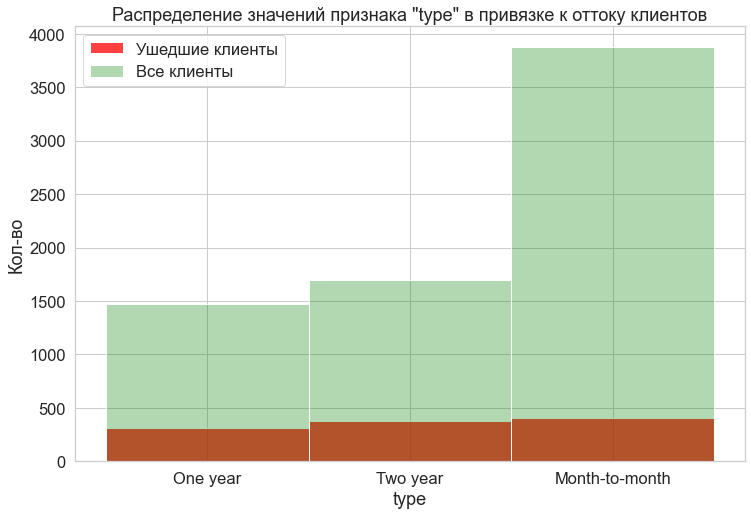

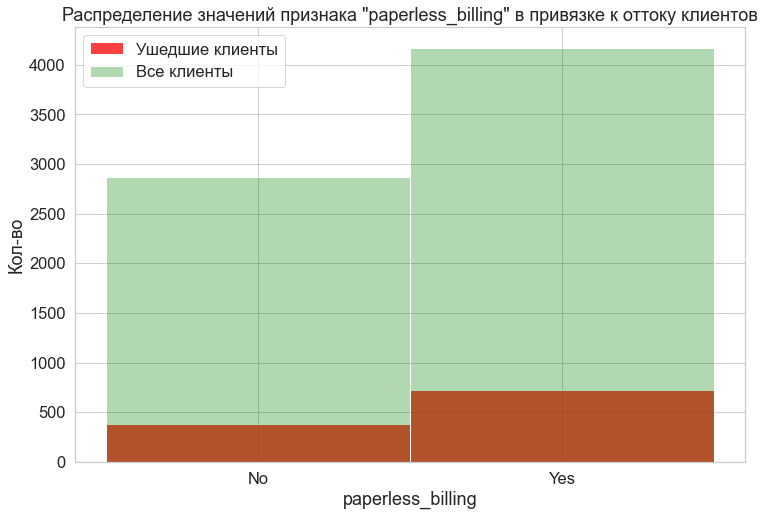

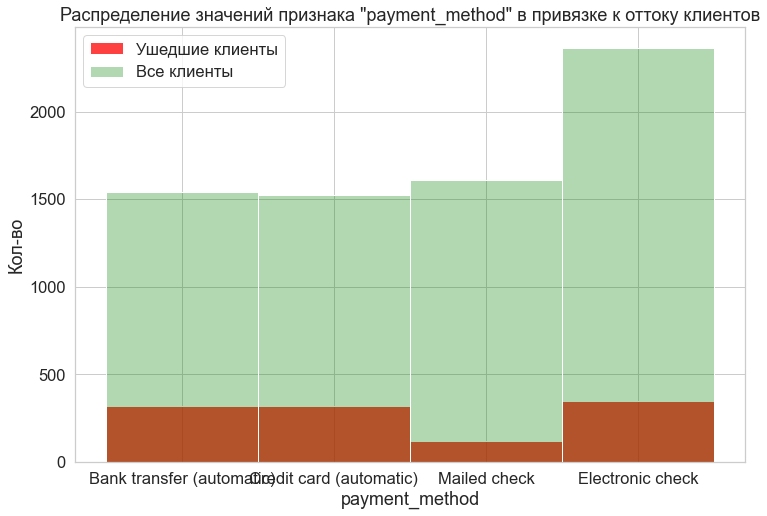

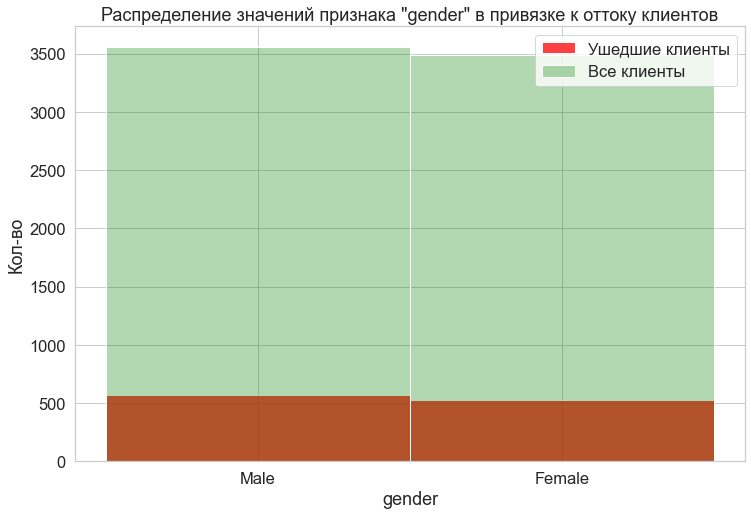

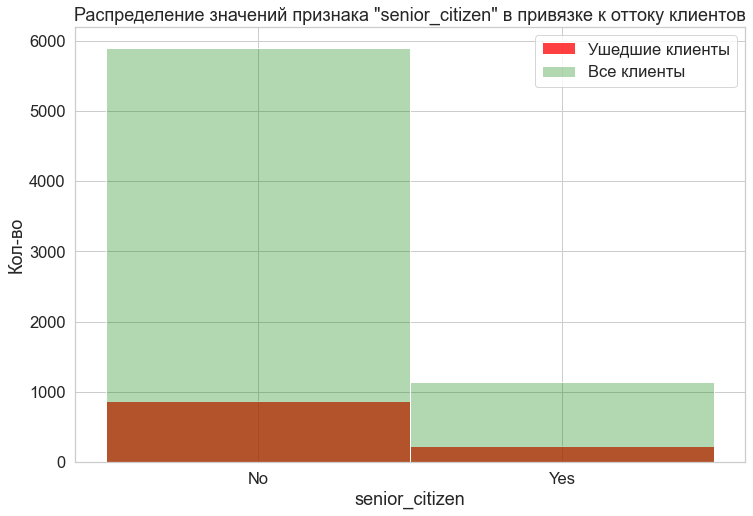

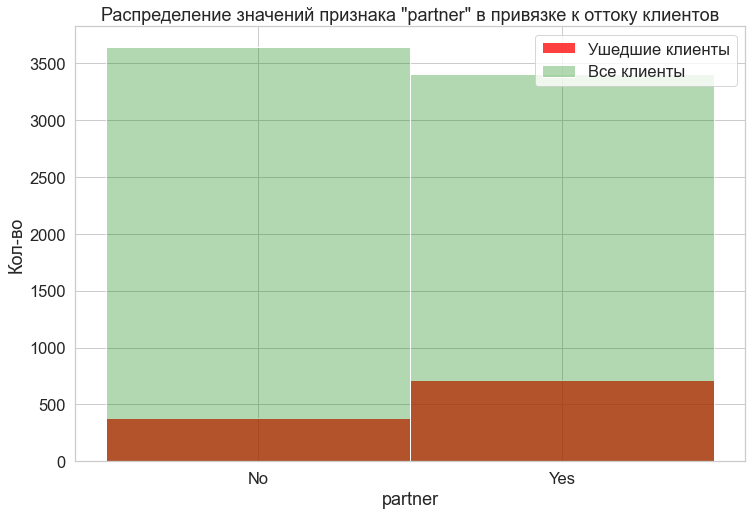

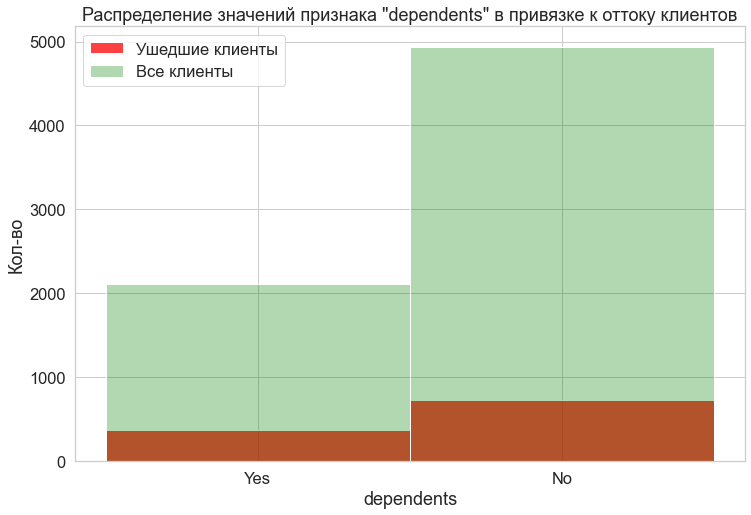

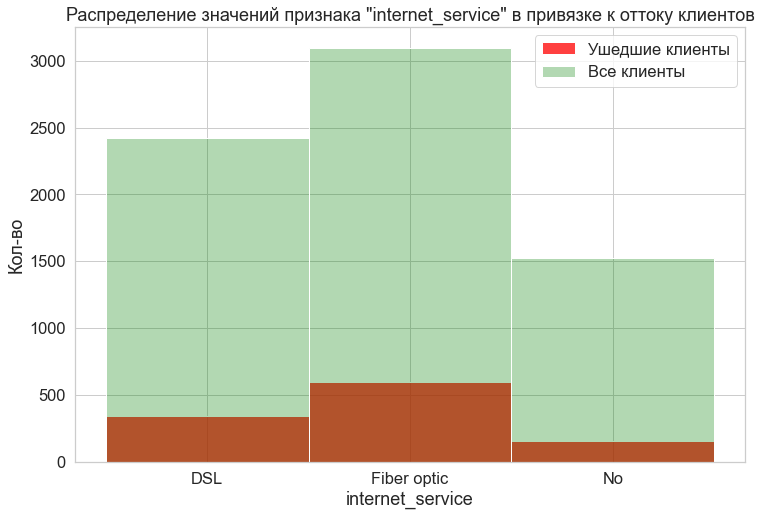

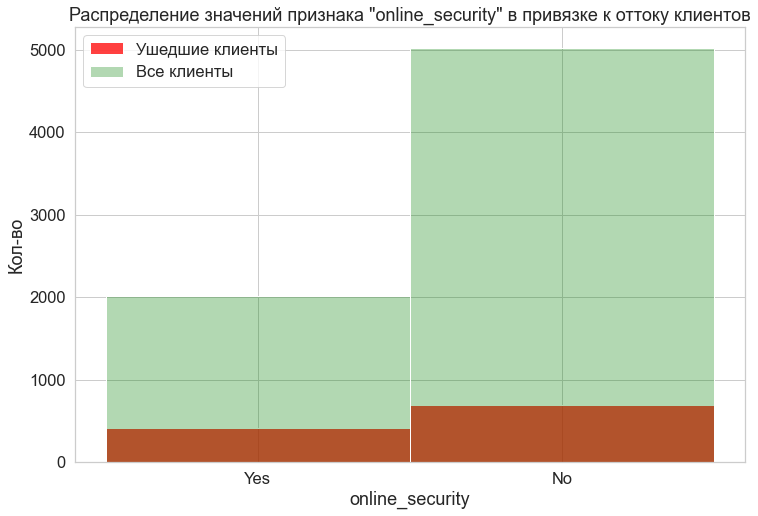

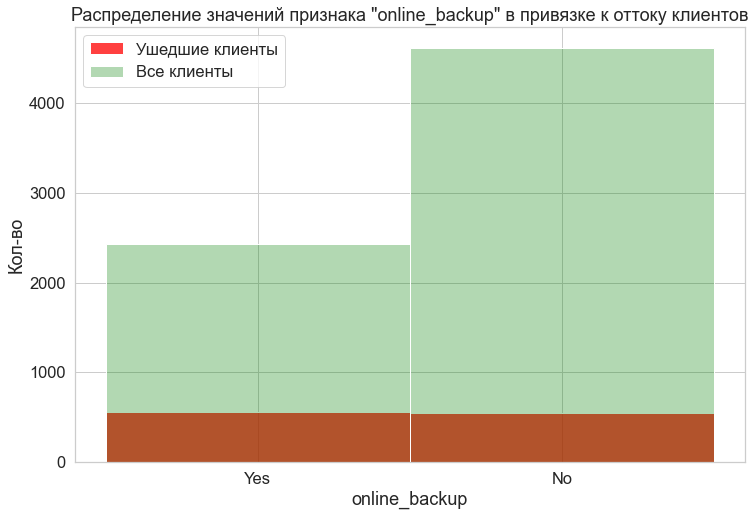

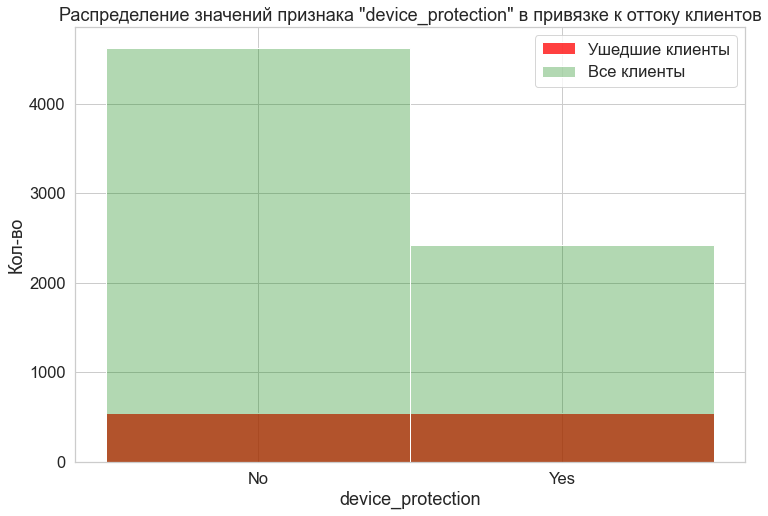

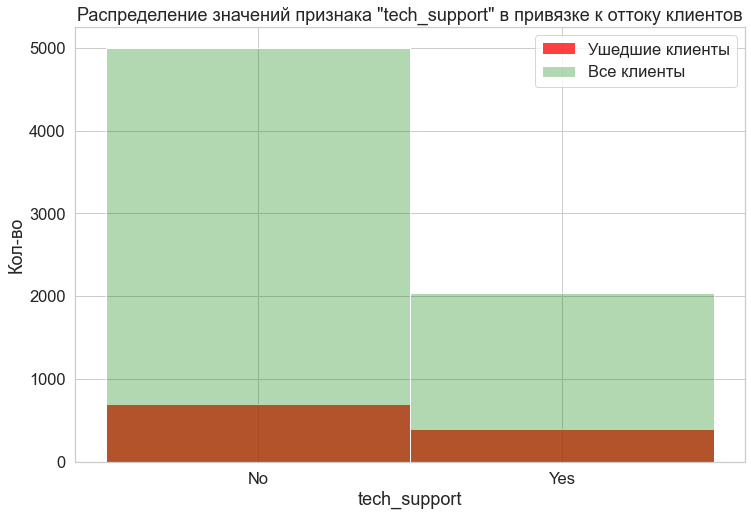

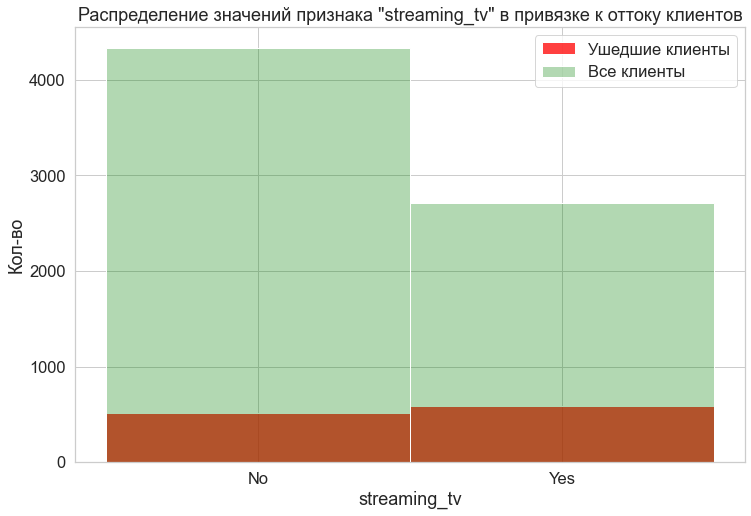

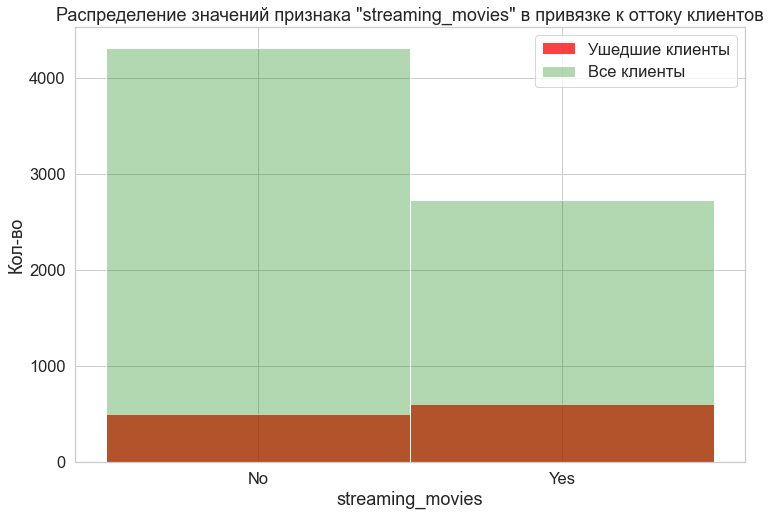

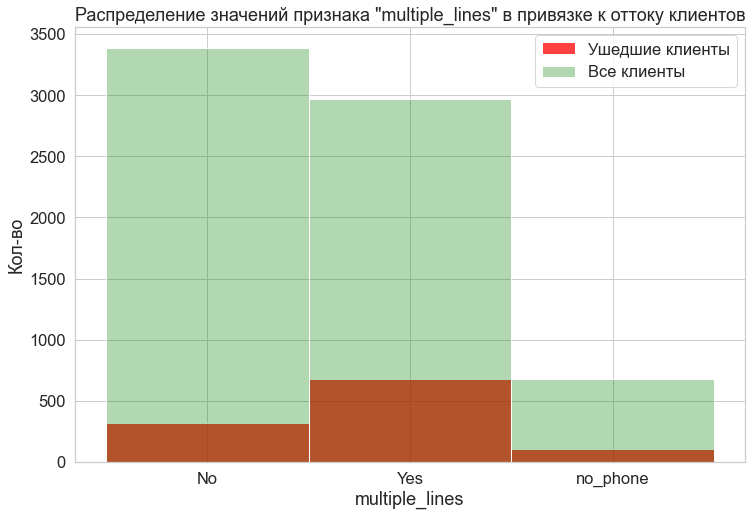

In [179]:
for col in cat:
    
    plt.figure(figsize=[12, 8])
    ax = sns.histplot(df_eda[df_eda['churn'] == 1][col], 
                  color='red',
                  label='Ушедшие клиенты')
    sns.histplot(df_eda[col],
                 color='green',
                 ax=ax, 
                 alpha=0.3, 
                 label='Все клиенты')
    ax.legend()
    plt.title(f'Распределение значений признака "{col}" в привязке к оттоку клиентов')
    plt.xlabel(col)
    plt.ylabel('Кол-во');

**Комментарий:** Итак, освежим немного в памяти характеристики пользователей и разбавим наиболее заметными инсайтами по оттоку: самый популярный тип договора - ежемесячный (55%), при этом объем оттока по нему примерно соответствует 2 другим типам договора, то есть в долевом соотношении по данному типу договора доля оттока примерно в 2 раза ниже; 59% клиентов предпочитают безбумажный чек, 34% предпочитают метод оплаты - электронный чек, он же на 2 месте по минимальности доли оттока, а на первом любители чека по почте; гендерные признаки распределены поровну во всех отношениях; к пенсионерам относятся только 16% клиентов; 59% не имеют партнера, при этом среди оставшихся 41% доля оттока выше примерно в 2 раза; 70% не имеют иждивенцев; 56% клиентов сидят на оптоволокне, однако среди DSL меньшинства и доля оттока ниже. Теперь по доп. сервисам: онлайн безопасность подключают только 37%, но уровень оттока среди них выше, онлайн бэкап используют 44%, но уровень оттока среди них выше, защиту устройства также подключают 44%, но среди них большая доля оттока, тех поддержку используют 37%, но доля оттока среди них немного выше, стриминг тв берут 49% и доля оттока среди них выше, стриминг фильмов используют 50% и среди них также более высокая доля оттока, 47% пользователей использует мультилинии и уровень оттока среди них выше. 

Если кратко, то наиболее явственно и единодушно показывают большую долю оттока признаки наличия доп. сервисов: среди пользователей этих сервисов доля оттока выше. Возможно это связано с качеством сервисов, а возможно с доп. расходами на них. Также стоит отметить, что меньше оттока среди пользователей ежемесячных договоров и оплаты почтовым чеком. 

**Работа с численными значениями:** Теперь подробнее рассмотрим распределения численных значений в связке с оттоком клиентов.

In [180]:
num = df_eda.select_dtypes(exclude='object').columns.to_list()
num.remove('churn')

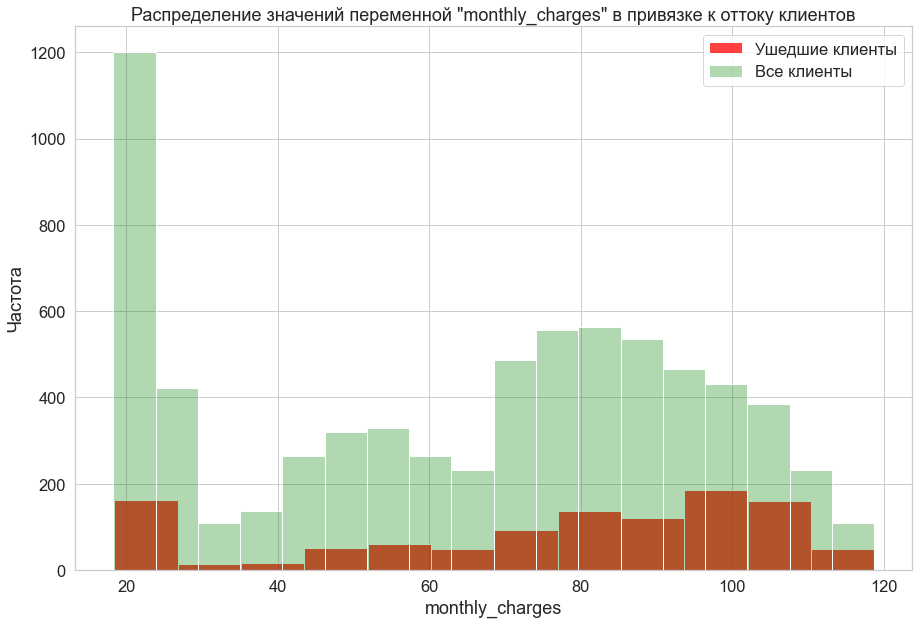

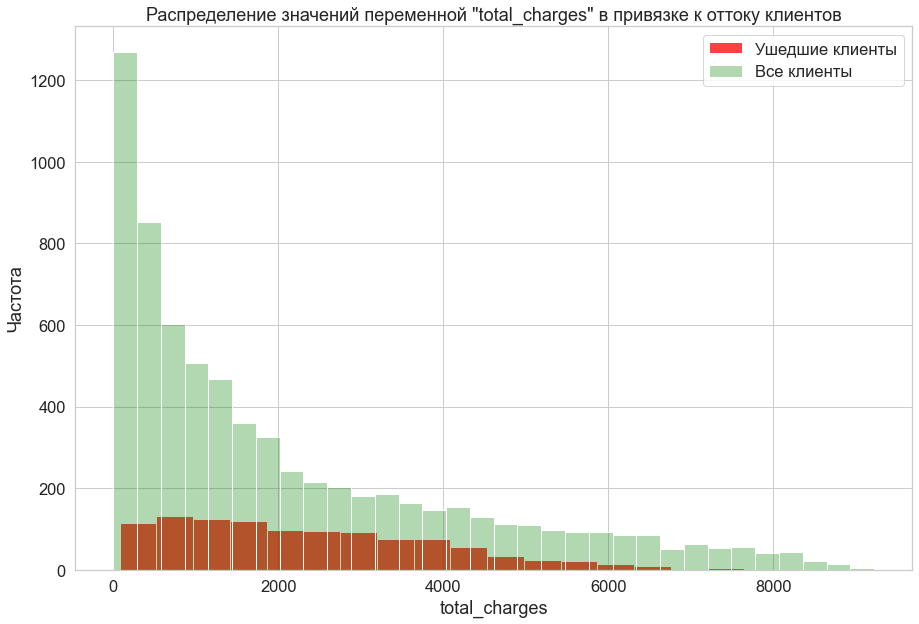

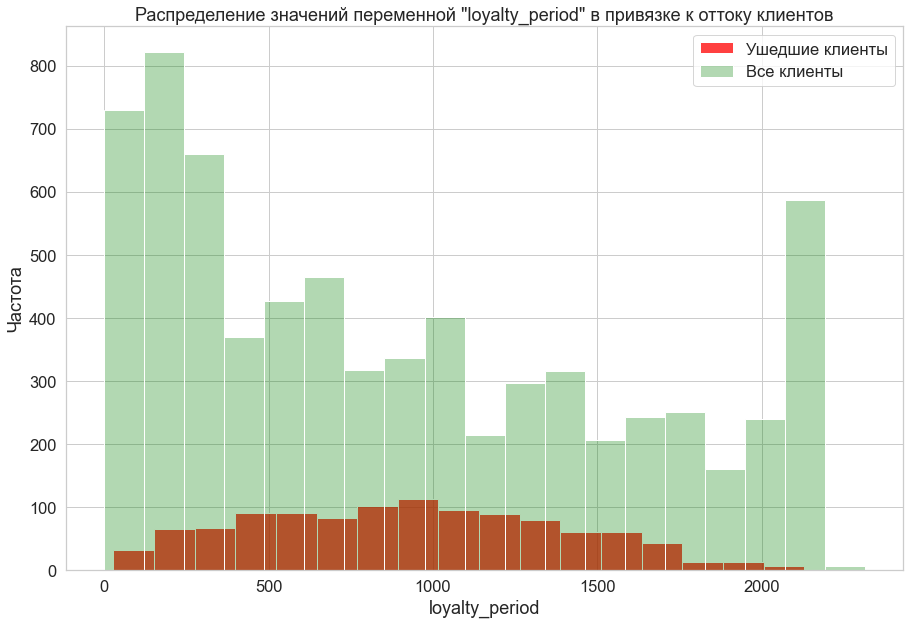

In [181]:
for col in num:
    
    plt.figure(figsize=[15, 10])
    ax = sns.histplot(df_eda[df_eda['churn'] == 1][col], 
                      color='red',
                      label='Ушедшие клиенты')
    sns.histplot(df_eda[col],
                 color='green',
                 ax=ax, 
                 alpha=0.3, 
                 label='Все клиенты')
    ax.legend()
    plt.title(f'Распределение значений переменной "{col}" в привязке к оттоку клиентов')
    plt.xlabel(col)
    plt.ylabel('Частота');

**Комментарий:** Относительно значений клиентского стажа уровень оттока распределен более менее нормально, разве что есть дисбаланс в сторону клиентов с коротким стажем: после 1600-1700 дней доля ушедших заметно падает. По итоговым затратам на суммах свыше 7000 единиц доля оттока совсем падает - скорее всего это уже зона максимальных лоялистов, у которых сумма затрат сложилась такой из-за длительного срока пользования. В зоне маленьких итоговых затрат новые пользователи - не такая большая часть их успевает так быстро сбежать. Поэтому самая высокая доля оттока сконцентрировалась где-то от 2000 до 4500 единиц. 

По ежемесячным затратам опять видим, что к нас распределение с несколькими пиками. Можно примерно выделить 3 диапазона: от 18 до 35, от 35 до 70 и свыше 70 (добавим соответствующий столбец, чтобы посмотреть, как ведут себя показатели у разных ценовых групп). Отток тоже отрабатывает эти пики, правда у оттока еще появляется самый большой акцент уже на затратах в районе 100-120, где получаются самые высокие его доли. Получается, что доля оттока выше там, где ежемесячные траты у своих максимумов. Это перекликается с повышенными долями оттока у пользователей доп. сервисов. 

**Работа с ценовыми группами клиентов:**

In [182]:
# пишем функцию для категоризации ценовых групп клиентов
def categorize_charges(monthly_charges):
    try:
        if monthly_charges < 35:
            return 'light'
        elif 35 <= monthly_charges < 70:
            return 'middle'
        elif monthly_charges >= 70:
            return 'high'
    except:
        pass

In [183]:
# добавляем столбец с категориями ценовых групп клиентов

df_eda['monthly_charges_cat'] = df_eda['monthly_charges'].apply(categorize_charges)

df_eda['monthly_charges_cat'].value_counts()

high      3591
light     1731
middle    1721
Name: monthly_charges_cat, dtype: int64

**Комментарий:** По составу получились неравные группы: примерно по четверти в малых и средних расходах и около половины в высоких. Посмотрим, как отток распределен в них.

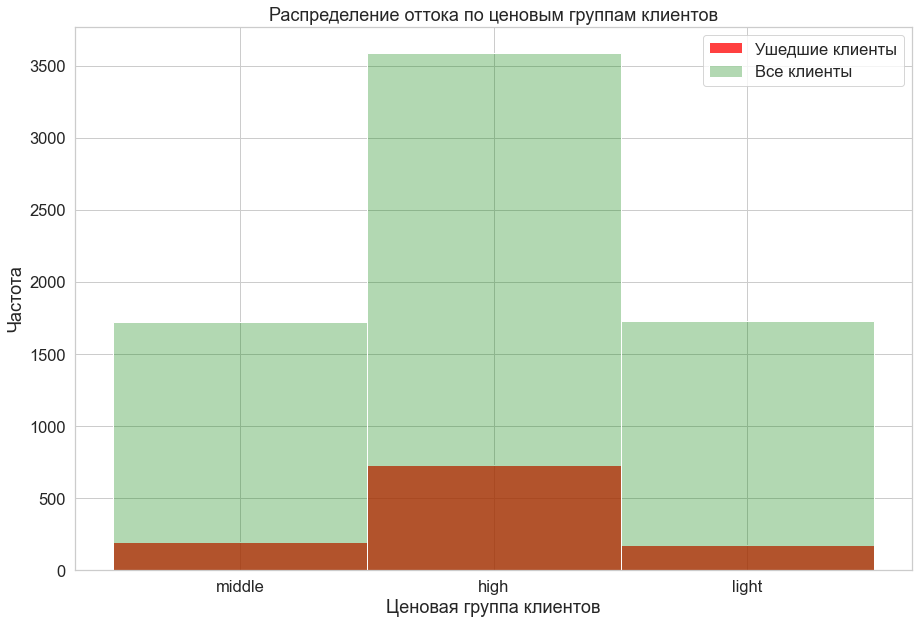

In [184]:
plt.figure(figsize=[15, 10])
ax = sns.histplot(df_eda[df_eda['churn'] == 1]['monthly_charges_cat'], 
                  color='red',
                  label='Ушедшие клиенты')
sns.histplot(df_eda['monthly_charges_cat'],
             color='green',
             ax=ax, 
             alpha=0.3, 
             label='Все клиенты')
ax.legend()
plt.title(f'Распределение оттока по ценовым группам клиентов')
plt.xlabel('Ценовая группа клиентов')
plt.ylabel('Частота');

**Комментарий:** Хоть группа с высокими расходами и занимает 50% пользователей, но оттока на нее приходится не менее 2 третей, то есть в долевом соотношении в данной ценовой группе больше оттока. Собственно, это перекликается с предыдущими наблюдениями. Посмотрим дополнительно, как сервисы распределены по "дорогой" ценовой группе.

In [185]:
services = ['multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', \
            'tech_support', 'streaming_tv', 'streaming_movies']

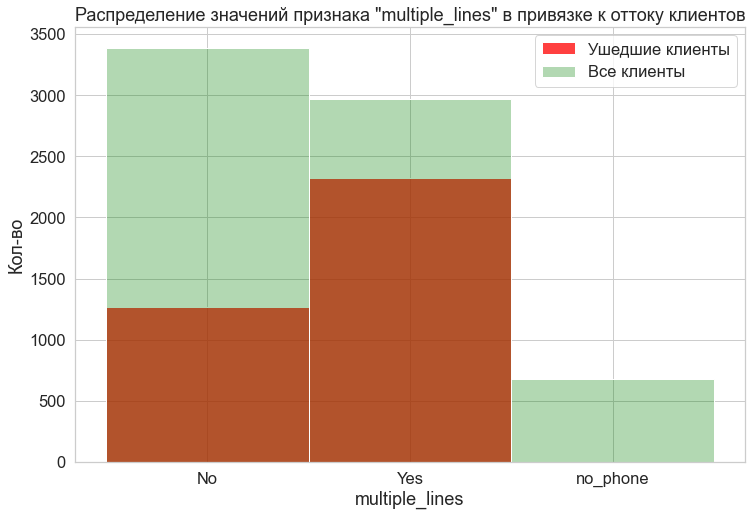

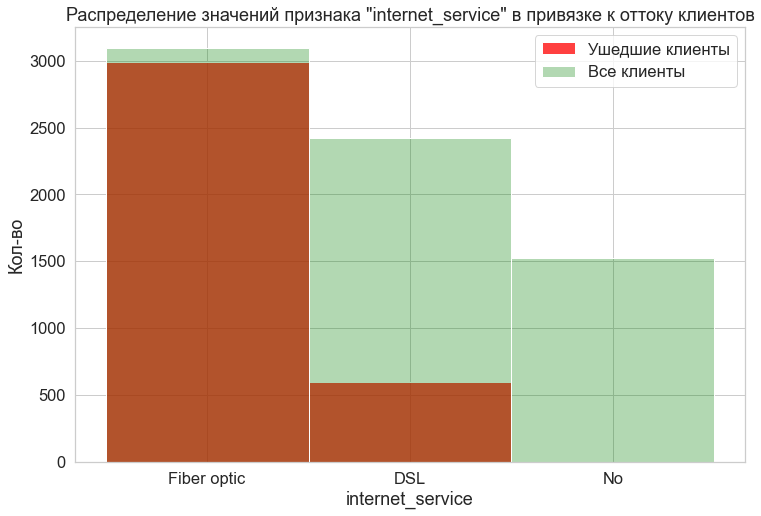

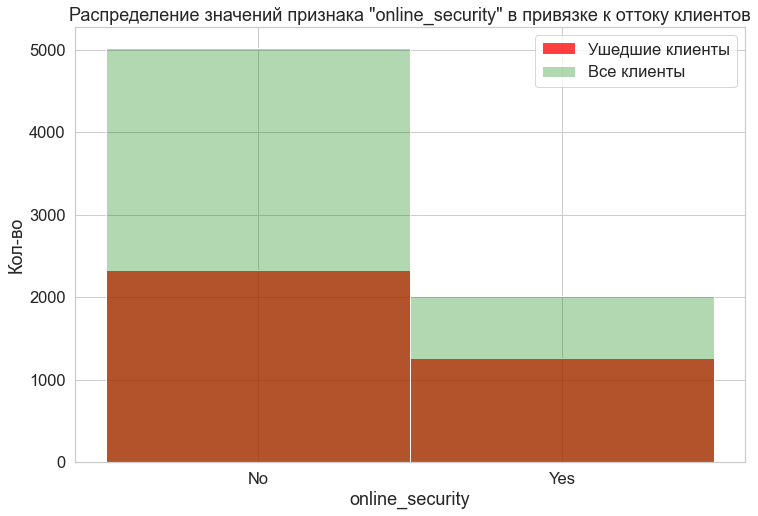

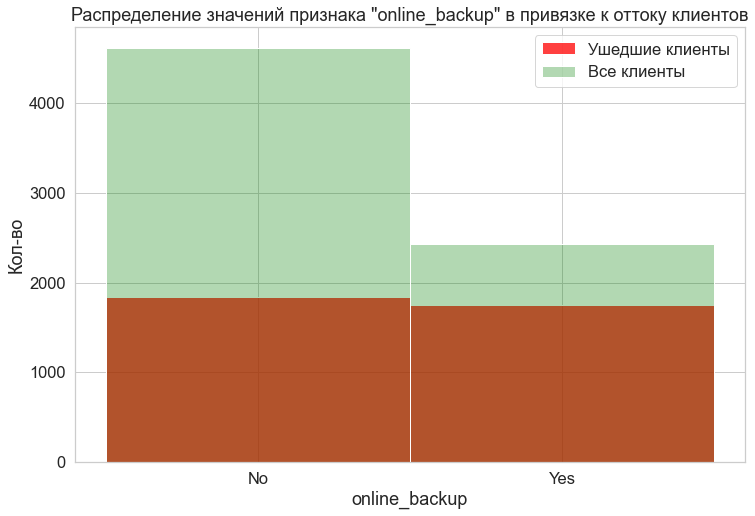

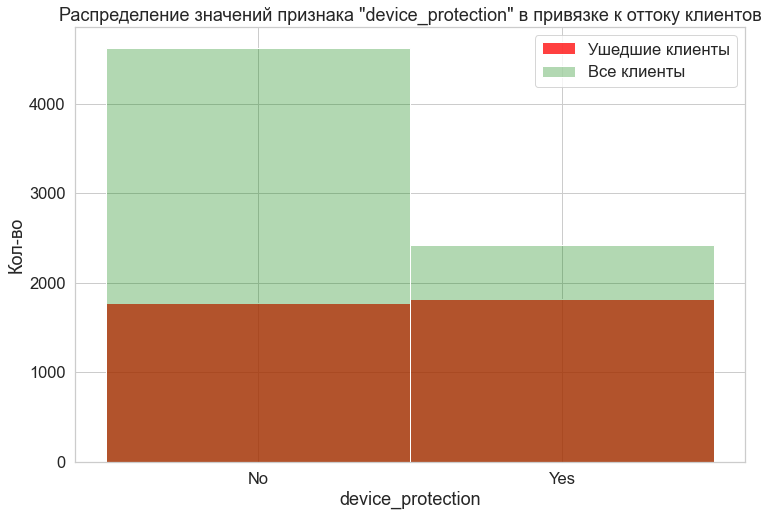

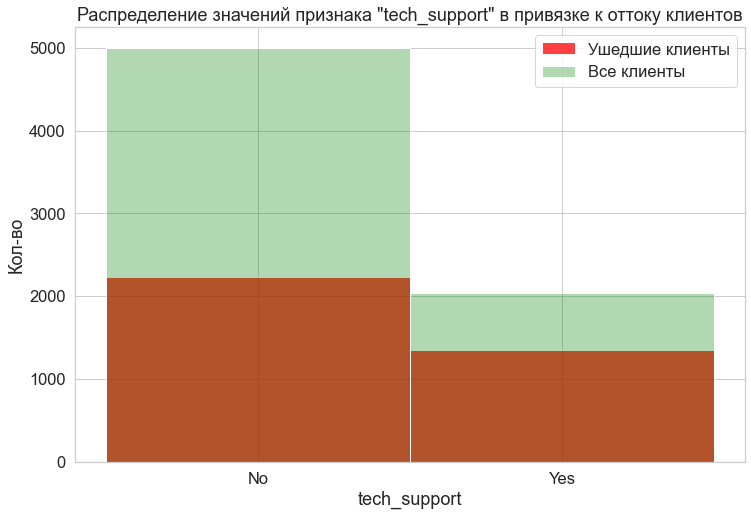

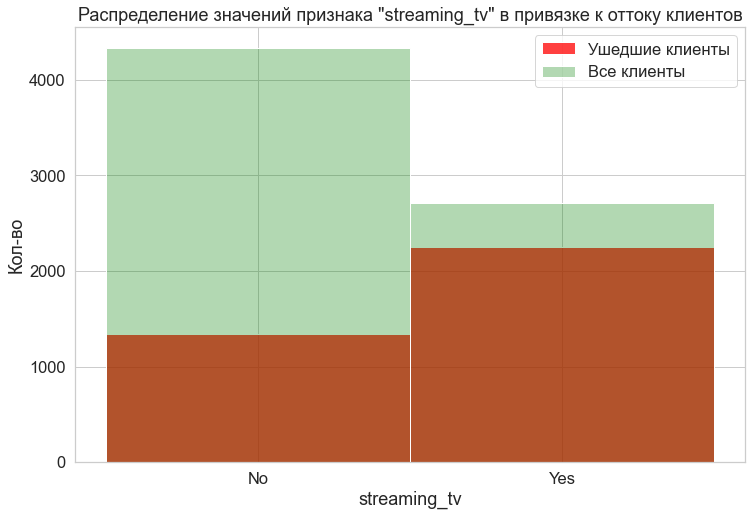

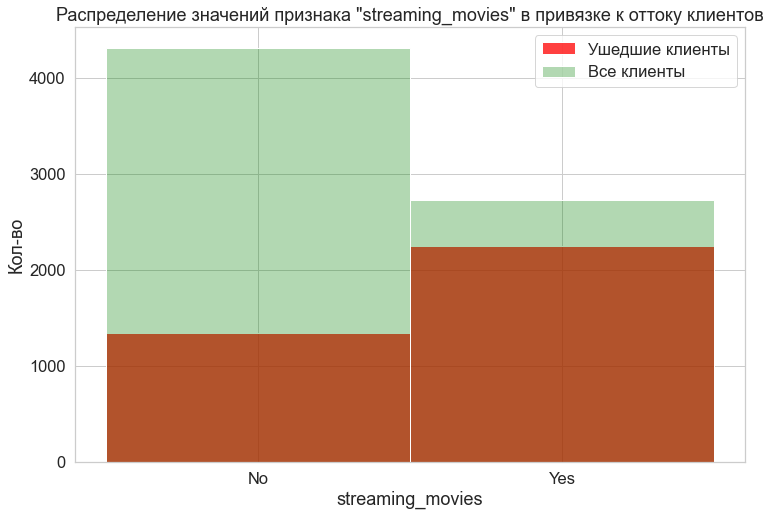

In [186]:
for col in services:
    
    plt.figure(figsize=[12, 8])
    ax = sns.histplot(df_eda[df_eda['monthly_charges_cat'] == 'high'][col], 
                  color='red',
                  label='Ушедшие клиенты')
    sns.histplot(df_eda[col],
                 color='green',
                 ax=ax, 
                 alpha=0.3, 
                 label='Все клиенты')
    ax.legend()
    plt.title(f'Распределение значений признака "{col}" в привязке к оттоку клиентов')
    plt.xlabel(col)
    plt.ylabel('Кол-во');

**Комментарий:** Что логично, большинство пользователей доп. сервисов сосредоточены в дорогой ценовой группе клиентов, а также почти все пользователи оптоволоконного подключения, похоже это и есть основные составляющие высокой ежемесячной платы. Интересно, что среди ушедших в этой ценовой группе не было никого из тех, кто использует только один сервис (телефон или интернет).

**Выжимка анализа распределения оттока:** Посмотрим еще раз на распределение классов относительно числовых переменных на одном графике.

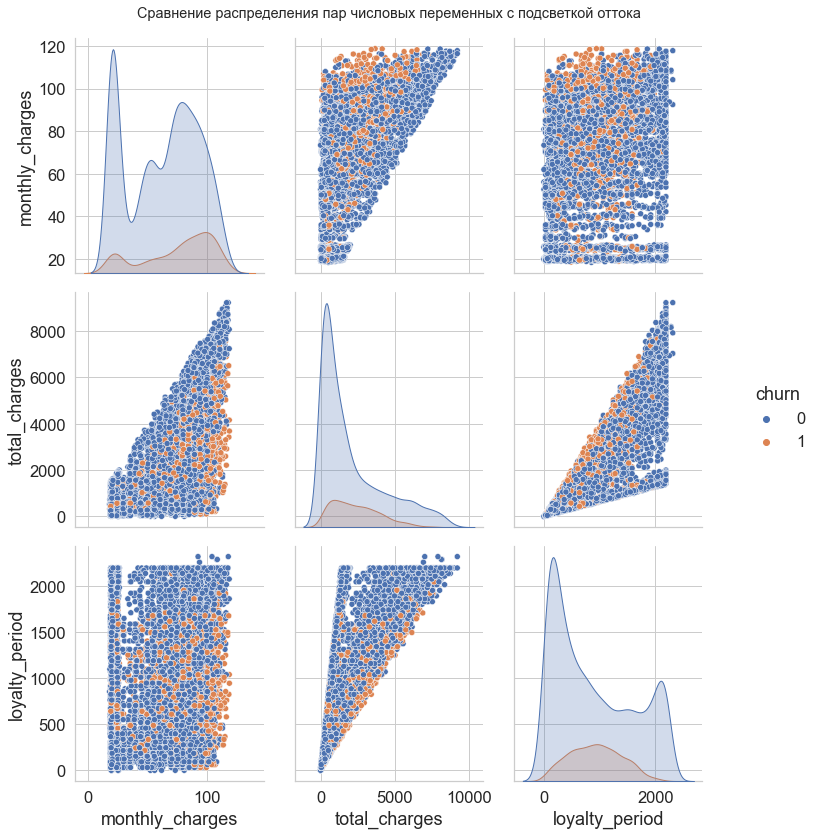

In [187]:
g = sns.pairplot(df.drop(['senior_citizen'], axis=1),
                 hue='churn'
                )
sns.set(style='whitegrid')
g.fig.set_size_inches(12,12)
g.fig.suptitle("Сравнение распределения пар числовых переменных с подсветкой оттока", y=1.01)
sns.set(style='whitegrid',font_scale=1.5);

**Комментарий:** Итак еще раз видим уже отмеченные ранее нюансы: отток, видимо, больше концентрируется там, где выше ежемесячные платежи, также при небольшом и особенно при очень длительном стаже оттока клиентов существенно меньше, основной отток сосредоточен на среднем диапазоне стажа и тем больше концентрируется, чем выше месячные затраты. Посмотрим корреляцию.

In [188]:
#посмотрим корреляцию Пирсена по численным данным
df[num].corr()

,monthly_charges,total_charges,loyalty_period
monthly_charges,1.000000,0.630440,0.220054
total_charges,0.630440,1.000000,0.821746
loyalty_period,0.220054,0.821746,1.000000


**Комментарий:** Из-за высокого значения линейной связи между фичами, а именно: итоговыми тратами и длительностью действия контракта, есть риск мультиколлинеарности при использовании линейных моделей. Можно попробовать компенсировать это с помощью специальных гиперпараметров, имеющихся у некоторых линейных моделей или удалить столбец с итоговыми затратами, так как он, в сущности, получается из  ежемесяцных расходов и длительности договора.

In [189]:
#так как у нас много категориальных данных, используем Phik, чтобы соотнести их между собой и с численными признаками
phik_overview = df.phik_matrix(interval_cols=num)
phik_overview

/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected v

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,loyalty_period,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.244410
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.099953
payment_method,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.174849
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.709983
total_charges,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,0.135650,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.467787
churn,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.105101
loyalty_period,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.347289
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.087925
partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.453688,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.086249


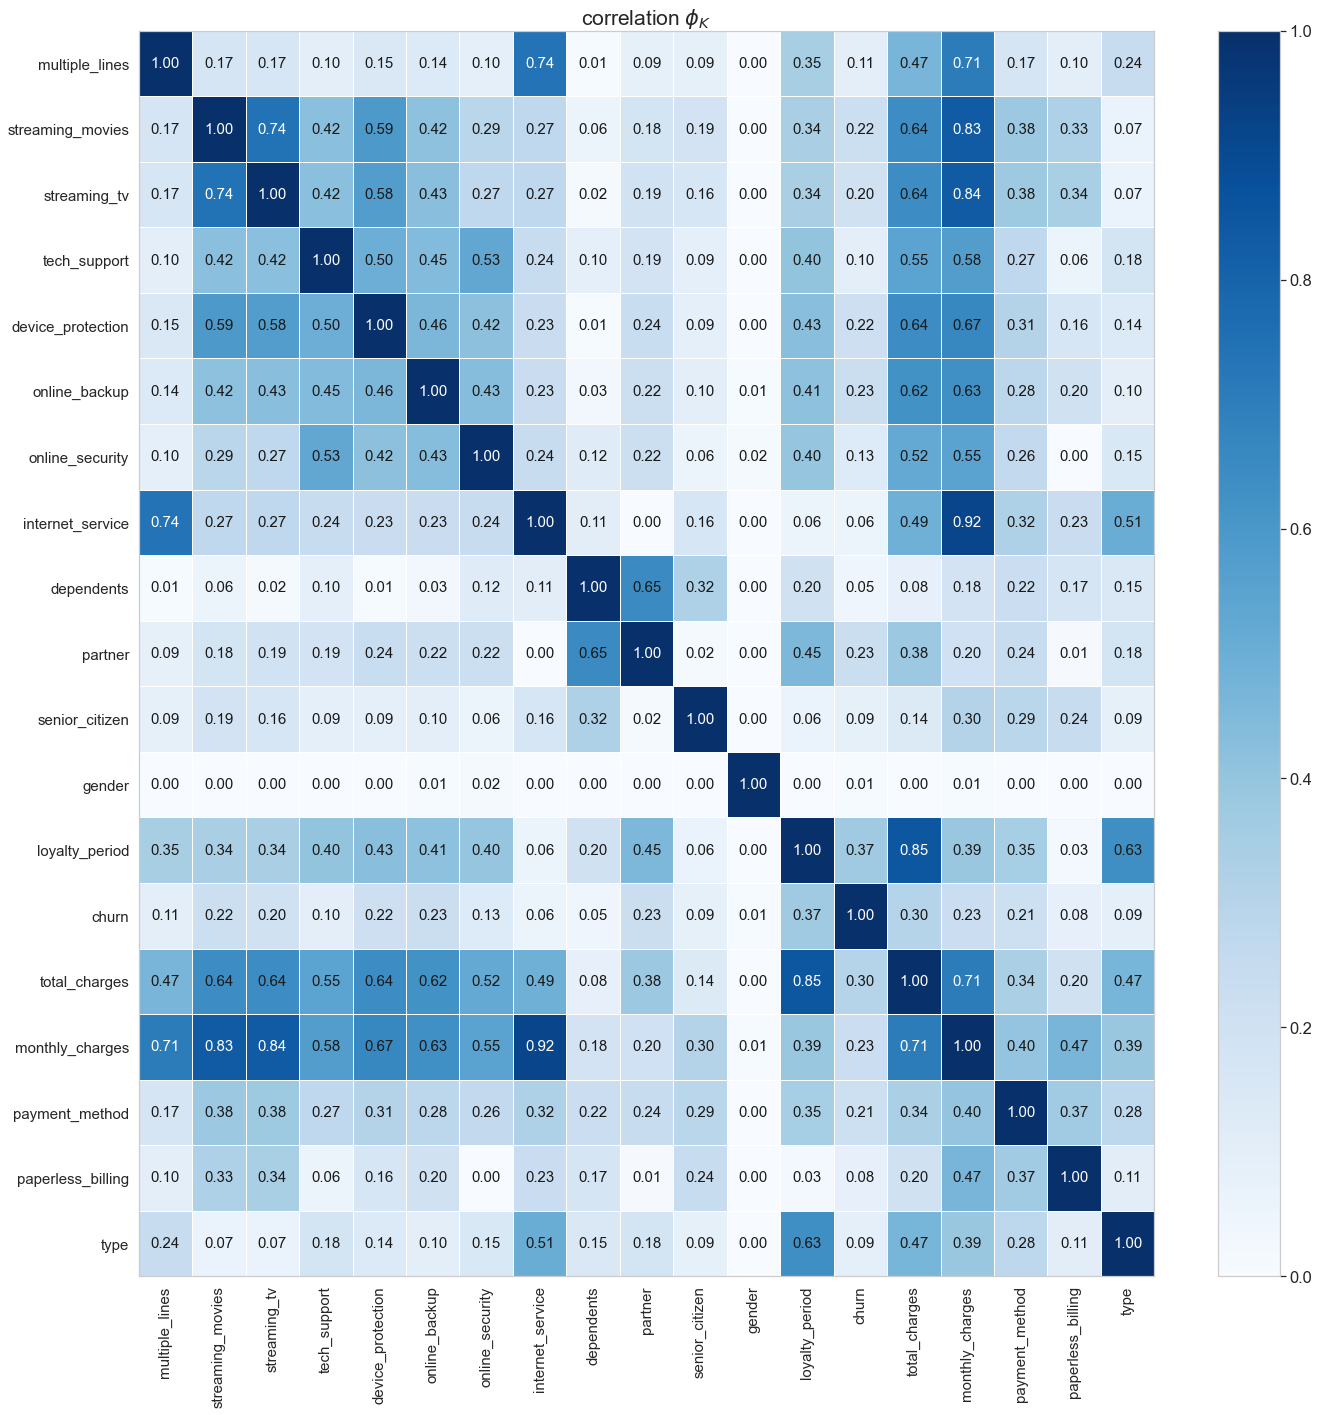

In [190]:
#визуализируем более наглядно
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))

**Комментарий:** Phik также показал высокое значение корреляции между численными признаками стажа клиента и итоговых затрат (0.85), а также выдал много высоких значений для связи между численными данными о ежемесячных тратах и категориальными данными о наличии сервисов стриминнг фильмов (0.83), стриминг ТВ (0.84) и наибольшее значение для типа интернет подключения (0.92). Ранее мы уже изучили, что месячные платежи связаны с оттоком, они же состоят из сервисов, наличие которых тоже влияет на отток. Убрать итоговые затраты не проблема, их компенсирует стаж и месячный тариф, но если убрать и месячную плату, то информативности убудет, а если удалить отдельные сервисы, то как понять, какие из них важнее. Пока рискнем и удалим только итоговые затраты, так как корреляция между 2 численными фичами и попробуем помоделировать. Если результаты моделей будут не очень - будем дальше экспериментировать с набором фичей.

### Анализ баланса классов

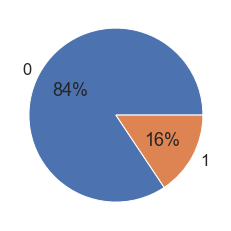

In [191]:
df['churn'].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%");

**Комментарий:** Налицо сильный дисбаланс классов. Учитывая относительно небольшой объем датасета есть некоторые риски, что модель плохо обучится определять именно класс оттока, но для начала попробуем обойтись без апсемплинга. При делении на выборки укажем параметр 'stratify', чтобы классы в выборках сохраняли баланс, аналогичный всему датасету. Наша метрика - AUC-ROC нечувствительна к дисбалансу классов, тем не менее, при обучении моделей будем пробовать учитывать баланс классов и посмотрим, сможет ли этот параметр улучшить показатели моделей.

## 3. Деление данных на выборки (train и test), определение целевых метрик и пороговых значений, отбор оптимальных моделей и гиперпараметров на валидационной выборке

In [192]:
RANDOM_STATE = 220523
TEST_SIZE = 0.25

cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', \
               'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', \
               'streaming_tv', 'streaming_movies', 'multiple_lines']

### Деление на выборки

In [193]:
features = df.drop(['total_charges', 'churn'], axis=1)
target = df['churn']

In [194]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target)

### Кодирование категориальных и масштабирование численных данных

In [195]:
features_train_lr = features_train.copy()

In [196]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [197]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('senior_citizen')
num_features

['monthly_charges', 'loyalty_period']

In [198]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_lr[ohe_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_lr[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_lr = features_train_lr.drop(ohe_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_lr[num_features] = scaler.fit_transform(features_train_lr[num_features])

In [199]:
features_train_lr

,monthly_charges,loyalty_period,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,multiple_lines_no_phone
5450,0.664236,-1.235291,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6056,0.213546,1.260148,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4612,-0.646258,1.570432,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
43,0.504582,1.481152,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
6860,1.237992,-0.481537,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,0.685856,1.880715,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2539,-1.286537,1.570432,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6646,-1.506061,0.946938,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5870,-1.289863,-1.011360,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [202]:
features_train_rf = features_train.copy()

In [203]:
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_rf[ohe_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_rf[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_rf[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_rf = features_train_rf.drop(ohe_features, axis=1)

In [204]:
features_train_rf

,monthly_charges,loyalty_period,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,multiple_lines_no_phone
5450,84.65,62,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6056,71.10,1767,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4612,45.25,1979,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
43,79.85,1918,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
6860,101.90,577,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,85.30,2191,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2539,26.00,1979,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6646,19.40,1553,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5870,25.90,215,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Кросс-валидация с подбором гиперпараметров для модели LogisticRegression

In [205]:
lr_params = { 'class_weight': ['balanced', None],
              'C': np.arange(0.1, 1.1, 0.1) }

lr_cv = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), 
                     param_grid=lr_params, scoring='roc_auc', n_jobs=-1, cv=5)
lr_cv_df = lr_cv.fit(features_train_lr, target_train)

In [206]:
print(f'Значения лучших регуляционных гиперпараметров для модели LogisticRegression: {lr_cv_df.best_params_}')
print(f'Значение лучшей метрики AUC-ROC модели LogisticRegression при кросс-валидации: {round(lr_cv_df.best_score_, 2)}')

Значения лучших регуляционных гиперпараметров для модели LogisticRegression: {'C': 0.30000000000000004, 'class_weight': 'balanced'}
Значение лучшей метрики AUC-ROC модели LogisticRegression при кросс-валидации: 0.76


### Кросс-валидация с подбором гиперпараметров для модели RandomForestClassifier

In [207]:
rf_params = { 'class_weight': ['balanced', None],
              'n_estimators': range(10, 51, 10),
              'max_depth': [1, 5, 10] }
rf_cv = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), 
                     param_grid=rf_params, scoring='roc_auc', n_jobs=-1, cv=5)
rf_cv_df = rf_cv.fit(features_train_rf, target_train)

In [208]:
print(f'Значения лучших регуляционных гиперпараметров для модели RandomForestClassifier: {rf_cv_df.best_params_}')
print(f'Значение лучшей метрики AUC-ROC модели RandomForestClassifier при кросс-валидации: {round(rf_cv_df.best_score_, 2)}')

Значения лучших регуляционных гиперпараметров для модели RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 40}
Значение лучшей метрики AUC-ROC модели RandomForestClassifier при кросс-валидации: 0.82


### Кросс-валидация с подбором гиперпараметров для модели CatBoostClassifier

In [212]:
cb_params = { 'auto_class_weights': ['Balanced', 'None'],
              'iterations': range(10, 51, 20),
              'depth': range(1, 6, 2),
              'learning_rate': np.arange(0.2, 0.9, 0.3) }
cb_cv = GridSearchCV(CatBoostClassifier(random_seed=RANDOM_STATE), 
                      param_grid=cb_params, scoring='roc_auc', n_jobs=-1, cv=5)
cb_cv_df = cb_cv.fit(features_train, target_train, cat_features=cat_features) 

0:	learn: 0.6819460	total: 54.8ms	remaining: 493ms
1:	learn: 0.6725993	total: 57.2ms	remaining: 229ms
2:	learn: 0.6599156	total: 59ms	remaining: 138ms
3:	learn: 0.6511724	total: 60.6ms	remaining: 90.9ms
4:	learn: 0.6438330	total: 63.2ms	remaining: 63.2ms
5:	learn: 0.6369785	total: 64.7ms	remaining: 43.2ms
6:	learn: 0.6311075	total: 66.3ms	remaining: 28.4ms
7:	learn: 0.6262084	total: 67.8ms	remaining: 17ms
8:	learn: 0.6174679	total: 69.6ms	remaining: 7.73ms
9:	learn: 0.6120379	total: 71.3ms	remaining: 0us
0:	learn: 0.6697137	total: 2.33ms	remaining: 21ms
1:	learn: 0.6392625	total: 4.56ms	remaining: 18.2ms
2:	learn: 0.6242931	total: 6.12ms	remaining: 14.3ms
3:	learn: 0.6148031	total: 7.65ms	remaining: 11.5ms
4:	learn: 0.6020637	total: 10ms	remaining: 10ms
5:	learn: 0.5879491	total: 11.7ms	remaining: 7.8ms
6:	learn: 0.5764900	total: 13.6ms	remaining: 5.82ms
7:	learn: 0.5614784	total: 15.7ms	remaining: 3.92ms
8:	learn: 0.5574481	total: 17ms	remaining: 1.89ms
9:	learn: 0.5522146	total: 18.9

In [213]:
print(f'Значения лучших регуляционных гиперпараметров для модели CatBoostClassifier: {cb_cv_df.best_params_}')
print(f'Значение лучшей метрики AUC-ROC модели CatBoostClassifier при кросс-валидации: {round(cb_cv_df.best_score_, 2)}')

Значения лучших регуляционных гиперпараметров для модели CatBoostClassifier: {'auto_class_weights': 'Balanced', 'depth': 5, 'iterations': 50, 'learning_rate': 0.8}
Значение лучшей метрики AUC-ROC модели CatBoostClassifier при кросс-валидации: 0.86


### Выбор лучшей модели

In [215]:
models_comparison = pd.DataFrame()
models_comparison['model'] = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
models_comparison['AUC-ROC'] = [lr_cv_df.best_score_, rf_cv_df.best_score_, cb_cv_df.best_score_]
models_comparison

,model,AUC-ROC
0,LogisticRegression,0.755421
1,RandomForestClassifier,0.819255
2,CatBoostClassifier,0.858390


**Вывод:** Лучший результат на кросс-валидации показала модель CatBoostClassifier со следующими параметрами: 'auto_class_weights': 'Balanced' (все-таки пригодилась балансировка классов), 'depth': 5, 'iterations': 50, 'learning_rate': 0.8. Теперь проверим ее на тестовых данных.

## 4. Проверка лучшей модели на тестовой выборке и проверка адекватности модели в сравнении с baseline

In [216]:
probabilities_test_cb_cv = cb_cv.best_estimator_.predict_proba(features_test)[:, 1]

In [217]:
print(f'Значение AUC-ROC на тестовой выборке: {round(roc_auc_score(target_test, probabilities_test_cb_cv), 4)}')

Значение AUC-ROC на тестовой выборке: 0.8805


**Комментарий:** Проходное значение целевой метрики достигнуто. Посмотрим на важность фичей и матрицу ошибок, это пригодится для понимания перспектив внедрения модели, как бизнес решения.

In [218]:
feature_importance = pd.DataFrame(cb_cv.best_estimator_.get_feature_importance(), index = features_test.columns, 
                                  columns=['importance']).sort_values(by='importance', ascending=False)
feature_importance

,importance
loyalty_period,46.278456
type,11.119423
monthly_charges,9.771880
payment_method,6.805939
multiple_lines,4.838378
partner,4.765677
streaming_movies,4.262215
dependents,2.832783
internet_service,2.510107
tech_support,1.878051


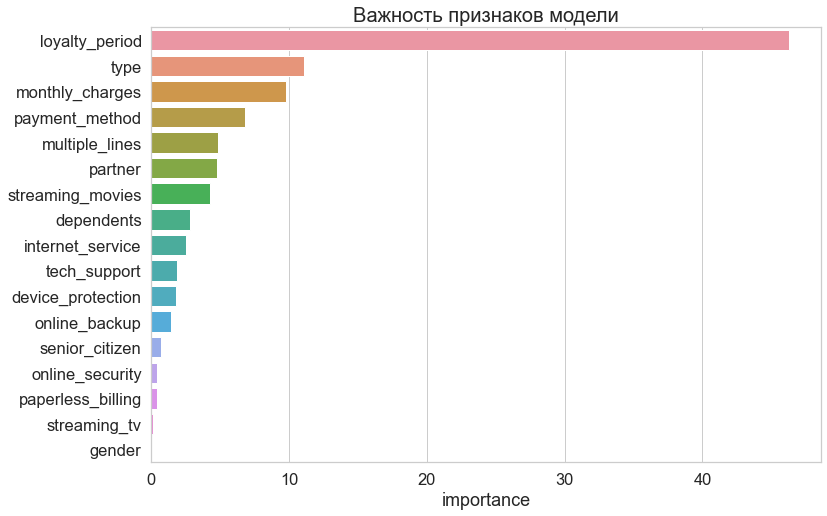

In [219]:
plt.figure(figsize=[12, 8])
plt.title('Важность признаков модели', fontsize=20)
sns.barplot(y=feature_importance.index, x=feature_importance['importance']);

**Комментарий:** Четверка самых влиятельных параметров: клиентский стаж (не зря мы его сгенерировали), тип договора, ежемесячные траты и тип оплаты, далее идут различные доп сервисы вперемешку с наличием партнера и иждивенцев. Впринципе, можно опробовать варианты получить метрику не сильно хуже на меньшем кол-ва параметров, что будет менее ресурсозатратно и потребуется собирать меньше данных.

In [220]:
predicted_test_cb = cb_cv.best_estimator_.predict(features_test)

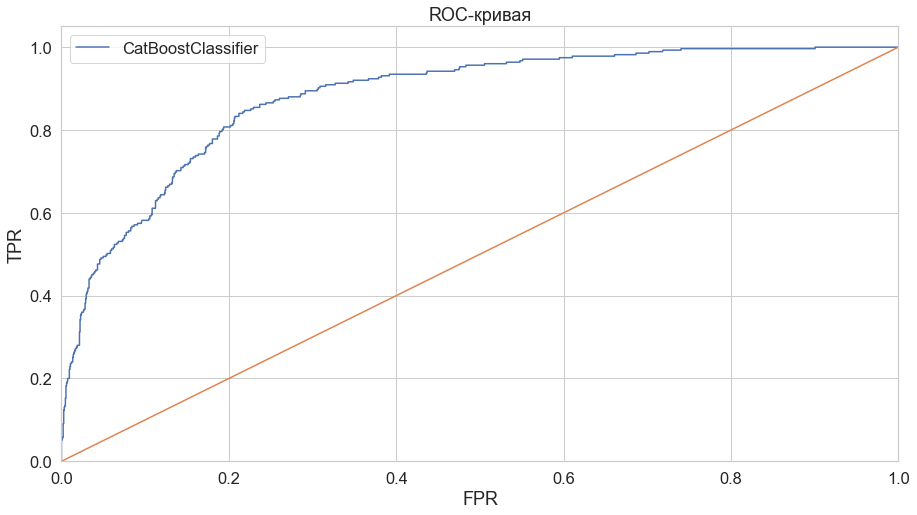

In [221]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test_cb_cv, pos_label=1)
plt.figure(figsize=[15, 8])
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend();

**Комментарий:** При живой построенной ROC-кривой нет смысла проверять модель на адекватность с помощью дамми-модели - результаты константной модели на графике - это желтая диагональ, площадь под кривой нашей модели явно больше. Посмотрим матрицу ошибок.

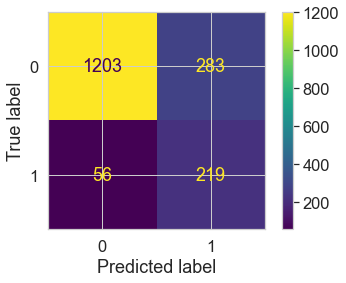

In [222]:
# confusion matrix plotting
cm = confusion_matrix(target_test, predicted_test_cb, labels=cb_cv.best_estimator_.classes_)

# labelling
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_cv.best_estimator_.classes_)
disp.plot()
plt.show();

**Комментарий:** Тут все уже не так безоблачно, как с целевой метрикой. Наша модель довольно много негативных значений предсказывает как 1, обратных ошибок ощутимо меньше. Тут можно поиграться с порогом, в зависимости от того, что для бизнеса дороже: подарить "плюшку" лишнему клиенту (который не собирается уходить на самом деле) или упустить лишнего клиента, которого не опознала модель из-за высокого порога. Небольшое кол-во предсказанных настоящих единиц можно объяснить сильным дисбалансом классов и небольшим объемом данных, апсемплинг мы не стали использовать. Еще бы собрать побольше датасет и может быть стратифицировать клиентов по их ценовым подходам, как вариант. Ниже пример изменения порога.

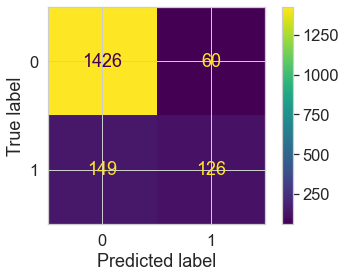

In [228]:
cb_cv.best_estimator_.set_probability_threshold(0.8)
predicted_test_cb = cb_cv.best_estimator_.predict(features_test)

# confusion matrix plotting
cm = confusion_matrix(target_test, predicted_test_cb, labels=cb_cv.best_estimator_.classes_)

# labelling
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_cv.best_estimator_.classes_)
disp.plot()
plt.show();

**Вывод:** Требуемое значение целевой метрики достигнуто, тратить дополнительные ресурсы на ее дальнейшую оптимизацию без команды тимлида нецелесообразно. Большой вывод-отчет будет в 3й части работы, поэтому пока кратко. 

## 5. Выводы (отчет) по проделанной работе и рекомендации

Итак, цель проекта была научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Целевой метрикой для заказчика - AUC-ROC с пороговым значением для подобранной модели не ниже 0.75 (в идеале не ниже 0.85). Для достижения цели были проделаны следующие шаги согласно плану:

**1.  В первой части мы произвели знакомство с данными и их первичную предобработку, а именно загрузили 4 датасета:**

- Contract (датасет с информацией о договорах) - 8 столбцов, 7043 строки с уникальными клиентами:

--'customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges'--

Были выявлены неявные пропуски (11 строк) в столбце с итоговыми тратами (total_charges), это оказались новые пользователи, у которых еще не было трат. Эти пропуски и пропуски с датах окончания контрактов заполнены, а главное, сгенерированы целевой признак - факт оттока клиентов (churn), исходя из наличия или отсутствия даты окончания контракта до заполнения пропусков, а также новый численный признак - клиентский стаж (loyalty_period) в днях, взятый из столбцов с датами начала и конца действия контракта, благодаря чему перед обучением можно будет избавиться от столбцов с датами, так как другой полезной для обучения информации они не несли. Выделение этих 2 признаков можно считать одним из ключевых шагов работы с данными.

- Personal (датасет с персональными данными клиентов) - 5 столбцов, 7043 строки с уникальными клиентами:

--'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'--

- Internet (датасет с информацией об интернет-услугах) - 8 столбцов, 5517 строк с уникальными клиентами (не у всех есть телефон):

--'customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
 'streaming_tv', 'streaming_movies'--

- Phone (датасет с информацией об услугах телефонии) - 2 столбца, 6361 строка с уникальными клиентами (не у всех есть интернет):

--'customer_id', 'multiple_lines'--

По всем датасетам были приведены в порядок наименования столбцов и типы данных. Проверено отсутствие дубликатов в идентификационных номерах клиентов и их соответствие между датасетами, чтобы можно было приступить к их объединению в один для удобства дальнейшей работы. Были предварительно изучены соотношения уникальных значений категориальных величин и распределения числовых.

Было выяснено, что у нас в распоряжении данные по контрактам с 1 октября 2013 по 01 февраля 2020, то есть за 6 лет и 4 месяца. При этом максимальное значение среди клиентских стажей в днях соответствует этому сроку, т.е. есть, как минимум один действующий клиент, который был с оператором с самого начала. Точнее таких клиентов 3, их номера id: "0917-EZOLA", "8580-QVLOC" и "2889-FPWR". Возможно, отделу маркетинга или клиентскому отделу также захочется как-то отработать и такую лояльность.

**2.  Были произведены более подробный анализ и подготовка данных, были выполнены следующие пункты:**

- Данные объединены в один датасет и сделана фигальная предобработка, а именно заполнены пропуски в категориальных значениях, возникшие из-за того, что не у всех пользователей были одновременно и услуги связи и интернета, поэтому недостающие значения были заполнены значением "No" для бинарных величин с такими вариантами значений (в случае с данными о типе интернет подключения, имевшем изначально варианты значений "DSL" и "Fiber_optic" добавленное значение "No" означало отсутсвие интернет сервиса, как такового, аналогичное значение, только уже для отсутствия сервиса связи стало иметь добавленное значение "No_phone" в столбец с бинарным признаком наличия доп. сервиса мультилиний, так как в изначальных значениях уже было "No", но нужно было не потерять информацию об отсутствии сервиса связи у части клиентов). 

- Анализ распределения данных выявил следующие наблюдения:

Большой приток новых пользователей был в начале 2014 года, видимо, когда о новом операторе узнало достаточное кол-во людей и скорее всего были какие-то заманчивые предложения, чтобы перебить конкурентов и взять долю рынка, потом с 2014 по 2016 шел спад с похожей динамикой в течение года, а с 2017 пошел рост притока, пик которого пришелся на 2019 год. Пики в 2014 и максимальным в 2019 скорее всего объясняют пики в кол-вах клиентов со стажем (loyalty_period) в районе 6 лет и максимальным в районе минимального стажа. Что касается распределения в рамках года, то мы не стали детально разбирать динамику в каждом году, посмотрели только 2 самых успешных и в среднем за весь период. В 2014 ярко выраженный пик пришелся на февраль, после шел постепенный спад, в 2019 же самыми успешными выдались последние 4 месяца года. Это скорее на заметку отделу маркетинга для лучшего понимания притока клиентов (только они смогут сопоставить эти показатели с датами рекламных компаний, акций и т.п.).

Отток клиентов был с 2014, но в сравнительно небольших объемах и постепенно рос, а концовка самого успешного по приросту 2019 года увенчалась и самыми высокими цифрами по оттоку, возможно частичный отток - это обратная сторона медали объема клиентов, чем их больше, тем больше и кол-во недовольных в реальном выражении, а доля их от общего объема стабильна. 

In [224]:
annual_clients

,begin_date_year,new_clients,total_clients,churn,churn_new_clients_ratio,churn_total_clients_ratio
0,2014,1344,1352,7,0.01,0.0052
1,2015,852,2204,62,0.07,0.0281
2,2016,763,2967,140,0.18,0.0472
3,2017,845,3812,235,0.28,0.0616
4,2018,1030,4842,285,0.28,0.0589
5,2019,1957,6799,333,0.17,0.0490
6,2020,244,7043,39,0.16,0.0055


Проверка динамики по доле ушедших клиентов от накопленной суммы по годам подтвердила эту гипотезу, темп оттока в долевом измерении даже замедлялся в 2018 и 2019 по сравнению с пиковым 2017 годом. Если же исследовать долю оттока клиентов относительно притока новых по годам, то там динамика ухудшалась до 2017 включительно, в 2018-2019 здесь тоже произошел позитивный спад, 2020й же только начался и по нему сложно делать какие-то выводы. В любом случае, радует, что стихийного характера отток не имеет, тем не менее, всегда есть, что попробовать оптимизировать. 

**Теперь можно было со спокойной душой удалить столбцы с датами из датасета, а заодно и id клиентов, что является важным шагом в подготовке данных для обучения модели.**

Характеристики пользователей вместе с наиболее заметными инсайтами по оттоку ("churn"): самый популярный тип договора **(type)** - ежемесячный (**month-to-month** - **55%**), при этом объем оттока по нему примерно соответствует 2 другим типам договора, то есть в долевом соотношении по данному типу договора доля оттока примерно в 2 раза ниже; **59%** клиентов предпочитают безбумажный чек (**paperless_billing**), **34%** предпочитают метод оплаты (**payment_method**) - электронный чек (**electronic_check**), он же на 2 месте по минимальности доли оттока, а на первом любители чека по почте (**mailed_check**); гендерные признаки (**gender**) распределены поровну (**50%**) во всех отношениях; к пенсионерам (**senior_citizen) относятся только **16%** клиентов; **59%** не имеют партнера (**partner**), при этом среди оставшихся 41% доля оттока выше примерно в 2 раза; **70%** не имеют иждивенцев (**dependables**); **56%** клиентов сидят на оптоволокне (**itnernet_service** = **optic_fibre**), однако среди DSL меньшинства и доля оттока ниже. Теперь по доп. сервисам: онлайн безопасность (**online_security**) подключают только **37%**, но уровень оттока среди них выше, онлайн бэкап (**online_backup**) используют **44%**, но уровень оттока среди них выше, защиту устройства (**device_protection**) также подключают **44%**, но среди них большая доля оттока, тех поддержку (**tech_support**) используют **37%**, но доля оттока среди них немного выше, стриминг тв (**streaming_TV**) берут **49%** и доля оттока среди них выше, стриминг фильмов (**streaming_movies**) используют **50%** и среди них также более высокая доля оттока, **47%** пользователей использует мультилинии (**multiple_lines**) и уровень оттока среди них выше.

**Если кратко, то наиболее явственно и единодушно показывают большую долю оттока признаки наличия доп. сервисов: среди пользователей этих сервисов доля оттока выше. Возможно это связано с качеством сервисов, а возможно с доп. расходами на них. Также стоит отметить, что меньше оттока среди пользователей ежемесячных договоров и оплаты почтовым чеком.**

Относительно значений клиентского стажа ("loyalty_period") уровень оттока ("churn") был распределен более менее нормально, разве что был дисбаланс в сторону клиентов с коротким стажем: после 1600-1700 дней доля ушедших заметно падала. По итоговым затратам на суммах свыше 7000 единиц доля оттока совсем падала - скорее всего это уже зона максимальных лоялистов, у которых сумма затрат сложилась такой из-за длительного срока пользования. В зоне маленьких итоговых затрат новые пользователи - не такая большая часть их успевает так быстро сбежать. Поэтому самая высокая доля оттока сконцентрировалась где-то от 2000 до 4500 единиц.

По ежемесячным затратам увидели, что распределение с несколькими пиками (мультимодальное). Можно примерно выделить 3 диапазона: от 18 до 35, от 35 до 70 и свыше 70 (добавили соответствующий столбец в аналитический датасет, чтобы посмотреть, как ведут себя показатели у разных ценовых групп). Отток тоже отрабатывает эти пики, правда у оттока еще появляется самый большой акцент уже на затратах в районе 100-120, где получаются самые высокие его доли. Получается, что доля оттока выше там, где ежемесячные траты у своих максимумов. Это перекликается с повышенными долями оттока у пользователей доп. сервисов.

По составу получились неравные группы: примерно по четверти в малых и средних расходах и около половины в высоких. Посмотрели, как отток распределен в них.
Хоть группа с высокими расходами и занимает 50% пользователей, но оттока на нее приходится не менее 2 третей, то есть в долевом соотношении в данной ценовой группе больше оттока. Это перекликалось с предыдущими наблюдениями. Посмотрели дополнительно, как сервисы распределены по "дорогой" ценовой группе.
Что логично, большинство пользователей доп. сервисов сосредоточены в дорогой ценовой группе клиентов, а также почти все пользователи оптоволоконного подключения, похоже это и есть основные составляющие высокой ежемесячной платы. Интересно, что среди ушедших в этой ценовой группе не было никого из тех, кто использует только один сервис (телефон или интернет).

**Ключевые наблюдения: отток ("churn") больше концентрируется там, где выше ежемесячные платежи, также при небольшом и особенно при очень длительном стаже ('loyalty_period") отток клиентов существенно меньше, основной отток сосредоточен на среднем диапазоне стажа и тем больше концентрируется, чем выше месячные затраты.**

- При изучении корреляции корреляции численных признаков были выявлены следующие взаимосвязи:

Из-за высокого значения линейной связи между признаками есть риск мультиколлинеарности при использовании линейных моделей. Можно попробовать компенсировать это с помощью специальных гиперпараметров, имеющихся у некоторых линейных моделей или удалить какие-то из коррелирующих признаков. Метод phik показал высокое значение корреляции между численными признаками стажа клиента и итоговых затрат (**0.85**), а также выдал много высоких значений для связи между численными данными о ежемесячных тратах и категориальными данными о наличии сервисов стриминнг фильмов (**0.83**), стриминг ТВ (**0.84**) и наибольшее значение для типа интернет подключения (**0.92**). Ранее мы уже изучили, что месячные платежи связаны с оттоком, они же состоят из сервисов, наличие которых тоже влияет на отток. Убрать итоговые затраты не проблема, их компенсирует стаж и месячный тариф (из произведения которых они и состоят), но если убрать и месячную плату, то информативности убудет, а если удалить отдельные сервисы, то как понять, какие из них важнее? Решили для начала не удалять все, а только итоговые затраты, так как это корреляция между 2 численными призначками и посмотреть результаты моделирования. Если результаты моделей будут не очень - можно дальше экспериментировать с набором признаков. Как показал дальнейший ход событий, тактика была выбрана правильно.

- Анализ баланса классов показал сильный дисбаланс (**0 - 84%, 1 - 16%**). Учитывая относительно небольшой объем датасета есть некоторые риски, что модель плохо обучится определять именно класс оттока, но для начала попробуем обойтись без апсемплинга. При делении на выборки укажем параметр 'stratify', чтобы классы в выборках сохраняли баланс, аналогичный всему датасету. Наша метрика - AUC-ROC нечувствительна к дисбалансу классов, тем не менее, при обучении моделей будем пробовать учитывать баланс классов и посмотрим, сможет ли этот параметр улучшить показатели моделей. Данный шаг считаю одним из ключевых.

**3.  Было произведено моделирование в следующем порядке:**

- Поделили данные на выборки с учетом дисбаланса классов (указали параметр "stratify"), оставив на тестовую выборку 25% данных.

- Произвели кодирование категориальных признаков с помощью OneHotEncoder для линейной и деревянной моделей и масштабирование численных признаков только для линейной. Для модели градиентного спуска признаки оставили в исходном виде, только определили список категориальных признаков.

- Провели кросс-валидацию с подбором гиперпараметров для модели **LogisticRegression**, используя GridSearchCV с использованием целевой метрики AUC_ROC в качестве скоринга на кросс-валидации и вывели гиперпараметры лучшей модели ('C' (параметр регуляризации) - лучшее значение 0.3, 'class_weight' (веса классов): 'balanced' (сбалансированное, то есть с учетом дисбаланса, выявленного при анализе данных), а также средний лучший скор (см. сводную таблицу ниже)

- Провели кросс-валидацию с подбором гиперпараметров для модели **RandomForestClassifier**, используя GridSearchCV с использованием целевой метрики AUC_ROC в качестве скоринга на кросс-валидации и вывели гиперпараметры лучшей модели ('class_weight' (веса классов): 'balanced' (сбалансированное), 'max_depth' (максимальная глубина деревьев): 5, 'n_estimators' (количество деревьев): 40), а также средний лучший скор (см. сводную таблицу ниже)

- Провели кросс-валидацию с подбором гиперпараметров для модели **CatBoostClassifier**, используя GridSearchCV с использованием целевой метрики AUC_ROC в качестве скоринга на кросс-валидации и вывели гиперпараметры лучшей модели ('auto_class_weights' (атоматические веса для классов): 'Balanced' (сбалансированные), 'depth' (глубина деревьев): 5, 'iterations' (кол-во итераций): 50, 'learning_rate' (степень обучения): 0.8), а также средний лучший скор (см. сводную таблицу ниже)

In [225]:
models_comparison

,model,AUC-ROC
0,LogisticRegression,0.755421
1,RandomForestClassifier,0.819255
2,CatBoostClassifier,0.858390


- Выбор лучшей модели - **CatBoostClassifier с гиперпараметрами 'auto_class_weights' (атоматические веса для классов): 'Balanced' (сбалансированные), 'depth' (глубина деревьев): 5, 'iterations' (кол-во итераций): 50, 'learning_rate' (степень обучения): 0.8)** был произведен на основании максимального (в сравнении с другими двумя моделями) значения целевой метрики на тренировочных данныз (при кросс-валидации) **AUC_ROC - 0.86** (см. сводную таблицу выше).

Ключевыми шагами на данном этапе можно назвать корректное кодирование и масштабирование данных для первых двух моделей, позволяющее, по возможности, избежать утечки данных при кросс-валидации и последующем тестировании, если бы оно потребовалось. Также метрики моелей позволило увеличить использование гиперпараметров, учитывающих дисбаланс классов.

**4.  Затем была произведена проверка лучшей модели на тестовых данных:**

- Запуск лучшей модели на тестовых данных показал **значение AUC-ROC: 0.8805**, что не только выше порогового 0.75, но и выше отличного 0.85, значит, **требуемый результат достигнут**.

- Запуск baseline (dummy) модели на тестовых данных не делали, так как на построенном графике c ROC кривой нашей модели желтой линией обозначены предсказания константной модели, с которыми можно сравнить наш результат и убедиться в его превосходстве.

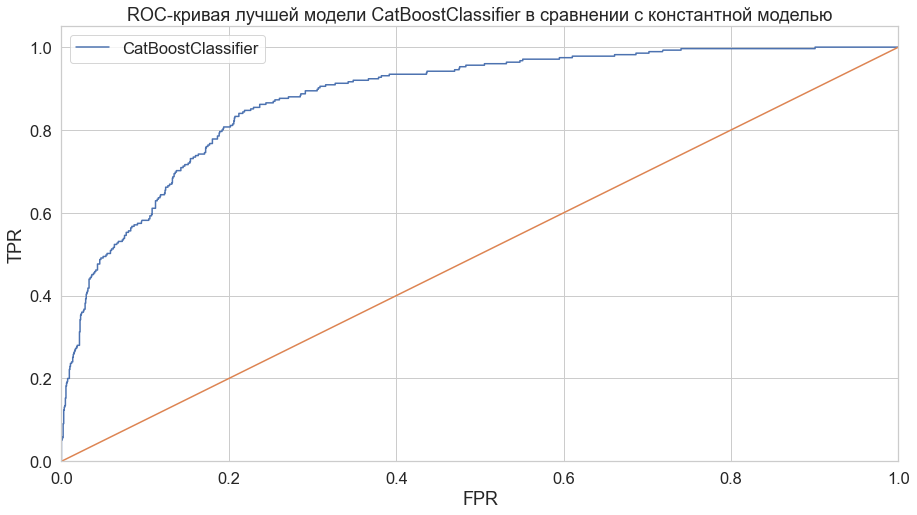

In [231]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test_cb_cv, pos_label=1)
plt.figure(figsize=[15, 8])
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая лучшей модели CatBoostClassifier в сравнении с константной моделью')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend();

- Анализ важности признаков модели дал следующие результаты:

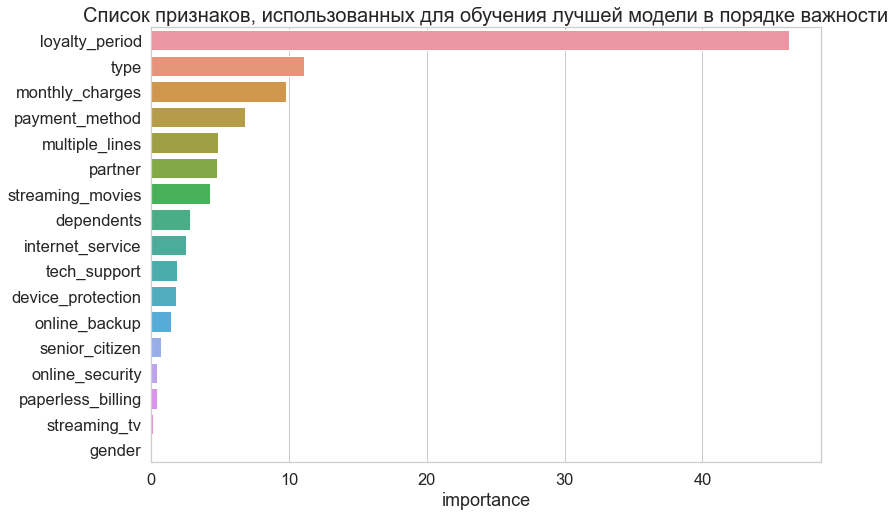

In [230]:
plt.figure(figsize=[12, 8])
plt.title('Список признаков, использованных для обучения лучшей модели в порядке важности', fontsize=20)
sns.barplot(y=feature_importance.index, x=feature_importance['importance']);

Четверка самых влиятельных параметров: клиентский стаж (loyalty_period - подтверждает, что его инжиниринг - один из ключевых шагов), тип договора (type), ежемесячные траты (monthly_charges) и тип оплаты (payment_method), далее идут различные доп сервисы вперемешку с наличием партнера и иждивенцев. Впринципе, можно опробовать варианты получить метрику не сильно хуже на меньшем кол-ва параметров, что будет менее ресурсозатратно для бизнеса и потребуется собирать меньше данных.

- Матрица ошибок

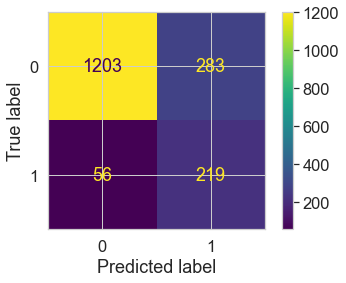

In [229]:
cb_cv.best_estimator_.set_probability_threshold(0.5)
predicted_test_cb = cb_cv.best_estimator_.predict(features_test)
cm = confusion_matrix(target_test, predicted_test_cb, labels=cb_cv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_cv.best_estimator_.classes_)
disp.plot()
plt.show();

Тут все уже не так безоблачно, как с целевой метрикой. Наша модель довольно много негативных значений предсказывает как 1, обратных ошибок ощутимо меньше. Тут можно поиграться с порогом, в зависимости от того, что для бизнеса дороже: подарить "плюшку" лишнему клиенту (который не собирается уходить на самом деле) или упустить лишнего клиента, которого не опознала модель из-за высокого порога. Небольшое кол-во предсказанных настоящих единиц можно объяснить сильным дисбалансом классов и небольшим объемом данных, апсемплинг мы не стали использовать. Еще бы собрать побольше датасет и может быть стратифицировать клиентов по их ценовым подходам, как вариант. 

- Выводы

Требуемое значение целевой метрики достигнуто, тратить дополнительные ресурсы на ее дальнейшую оптимизацию без обратной связи от заказчика нецелесообразно.